# ANALYZE tld_reseller model performance comparison - with reseller_geo

In [ ]:
options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)

In [ ]:
# install.packages("pkgcond")

In [ ]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)
library(dominanceanalysis)


getwd()

In [5]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('../phaseII_03_forest/functions_eval.R')


source('../phaseII_03_forest/load_prep_data_expiry.R')

# expiry_train_prepped_2_1 (list, less df's w/ 0 obs)
# expiry_test_prepped_2_1  (list, less df's w/ 0 obs)
# expiry_train_df_1 (above, rbound)
# expiry_test_df_1 (above, rbound)
# expiry_train_df_sub (subset vars)                                        
# expiry_test_df_sub (subset vars)

## List tld_reseller labels

In [6]:
tld_reseller_lookup_df = expiry_train_df_1 %>% group_by(tld_registrar_index, reseller) %>% tally() %>% arrange(desc(n))
tld_reseller_lookup_df %>% head()

tld_registrar_index,reseller,n
<chr>,<chr>,<int>
sitegmo,gmo,106569
funalibaba,alibaba,72690
sitenamecheap,namecheap,53536
pwnamecheap,namecheap,50470
onlinego daddy,go daddy,42162
sitegandi sas,gandi sas,35309


## Load PREPed tld_reseller compare

In [7]:
predictions_df <- read.csv("../../data/tld_reseller_compare_predictions.csv")
metrics_df <- read.csv("../../data/tld_reseller_compare_metrics.csv")

dim(predictions_df)
head(predictions_df)
dim(metrics_df)
head(metrics_df)

[1] 297100     12

,actual,pred_df_seg2_glm,pred_df_seg_glm,pred_df_agg_glm,pred_df_seg2_rf,pred_df_seg_rf,pred_df_agg_rf,tld_registrar_index,reseller,n,domain_id,domain
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>,<int>,<fct>
1,Not Renewd,0.6470992,0.558,0.419,0.4765771,0.4545657,0.5386137,sitegmo,gmo,106569,44295183,kagen.site
2,Renewed,0.6762222,0.567,0.397,0.5410605,0.5769973,0.6091513,sitegmo,gmo,106569,44573611,designlab.site
3,Renewed,0.9098495,0.835,0.410,0.7018108,0.6343404,0.6886680,sitegmo,gmo,106569,45304858,hokatu-blog.site
4,Renewed,0.6029350,0.515,0.402,0.2414726,0.3999603,0.3464197,sitegmo,gmo,106569,46235129,suzuya.site
5,Not Renewd,0.9311321,0.863,0.417,0.7749462,0.7039504,0.6711740,sitegmo,gmo,106569,46276970,wins-company.site
6,Renewed,0.9347869,0.861,0.391,0.6376848,0.6566740,0.6717237,sitegmo,gmo,106569,47809960,yamatoku-company.site


[1] 1723   15

,tld_registrar_index,reseller,n,l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,sitegmo,gmo,106569,8.204334,8.126935,6.408669,8.777090,8.761610,8.591331,0.8958204,0.8825077,0.8729102,0.9345201,0.9348297,0.9329721
2,funalibaba,alibaba,72690,4.883721,5.255814,5.023256,5.813953,6.000000,6.186047,0.8262791,0.8430233,0.8518605,0.8769767,0.8779070,0.8793023
3,sitenamecheap,namecheap,53536,2.298025,1.921005,1.885099,2.280072,2.028725,2.046679,0.6862657,0.6196589,0.6338420,0.6654399,0.6792639,0.6893178
4,pwnamecheap,namecheap,50470,3.478261,3.675889,3.675889,3.438735,4.071146,4.308300,0.7274704,0.6551383,0.6361660,0.7167984,0.7405138,0.7507905
5,onlinego daddy,go daddy,42162,2.850995,2.883271,2.474449,2.598171,2.727273,2.646584,0.6506455,0.6493007,0.6381119,0.6095481,0.6266541,0.6249328
6,sitegandi sas,gandi sas,35309,8.243243,8.445946,7.094595,4.932432,8.445946,8.581081,0.9202703,0.9195946,0.9189189,0.7162162,0.9344595,0.9358108


## Add reseller_geo to train_df before feature eng

In [8]:
head(expiry_train_df_1)

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,reseller_country,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count
<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>
FirstTime,1,2020-01-21,91584433,racefor.fun,2019-01-21,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,racefor,l,7,7l,1,2.70805,6.77,racefor,1,1,1
FirstTime,1,2020-01-30,92254793,united4.fun,2019-01-30,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-30,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,united4,ln,7,7ln,1,2.70805,8.65,united4,1,1,1
FirstTime,1,2020-02-04,92827233,bereal.fun,2019-02-04,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-04,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,bereal,l,6,6l,1,2.70805,13.09,bereal,1,1,1
FirstTime,1,2020-02-12,93490823,dogsoutdoors.fun,2019-02-12,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-12,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,dogsoutdoors,l,12,12l,1,2.70805,2.44,dogsoutdoors,1,1,1
FirstTime,1,2020-02-15,93767978,rosalux.fun,2019-02-15,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-15,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,rosalux,l,7,7l,1,2.70805,2.34,rosalux,1,1,1
FirstTime,1,2020-02-16,93823708,verygood.fun,2019-02-16,Active,fun,1&1 internet,1&1 internet,Germany,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-16,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,verygood,l,8,8l,1,2.70805,3.64,verygood,1,1,1


In [12]:
system("gsutil cp gs://data_input/PredictiveModelAnalysis_AnomalyRegistrars.csv /home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_AnomalyRegistrars.csv")
anomalyDF <- read.csv("/home/jupyter/local/Domains_202003/data/PredictiveModelAnalysis_AnomalyRegistrars.csv")
anomalyDF <- apply(anomalyDF, 2, function(x) trimws(x,which = c("both")) )
geoLookupDF <- unique(anomalyDF[,c('reseller','reseller_country','reseller_geo')])
geoLookupDF <- as.data.frame(geoLookupDF)
head(geoLookupDF)

,reseller,reseller_country,reseller_geo
,<fct>,<fct>,<fct>
1,007names,United States,United States
2,0101 internet,Hong Kong,China
3,1&1 internet,Germany,EU
4,101 domain,United States,United States
5,101domain discovery,Germany,EU
6,10dencehispahard,Spain,EU


In [16]:
# number of unique geos per reseller
geoLookupDF %>%
  group_by(reseller) %>%
  summarise(u_geo = n_distinct(reseller_geo))  %>%
  filter(u_geo>1)

`summarise()` ungrouping output (override with `.groups` argument)



reseller,u_geo
<fct>,<int>
hostgator,2
moniker,2
psi-japan,2
registrarsec,2
uk2,2
NA,2


In [17]:
# number of unique geos per reseller-country
geoLookupDF %>%
  group_by(reseller, reseller_country) %>%
  summarise(u_geo = n_distinct(reseller_geo))  %>%
  filter(u_geo>1)

`summarise()` regrouping output by 'reseller' (override with `.groups` argument)



reseller,reseller_country,u_geo
<fct>,<fct>,<int>
NA,NA,2


In [18]:
geoLookupDF %>% filter(is.na(reseller))

reseller,reseller_country,reseller_geo
<fct>,<fct>,<fct>
NA,NA,Others
NA,NA,NA


In [19]:
# ewnsure correct number of dimm
dim(expiry_train_df_1)
expiry_train_df_2 <- merge(expiry_train_df_1,geoLookupDF,on=c('reseller','reseller_country'), all.x = TRUE)
dim(expiry_train_df_2)
head(expiry_train_df_2)


[1] 1188250      39

[1] 1188250      40

reseller,reseller_country,renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,region,reg_period,registrant_country,renewal_status,renew_mbg,renew_type,autorenew_type,renew_date,renew_registrar,renew_reseller,reg_revenue,reg_arpt,renew_period,renew_domain_revenue,renew_arpt,reg_arpt_org,tld_registrar_index,sld,sld_type,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,pattern,cluster,pattern_score,pattern_domain_count,reseller_geo
<chr>,<chr>,<chr>,<int>,<date>,<int>,<chr>,<date>,<chr>,<fct>,<chr>,<chr>,<int>,<chr>,<fct>,<int>,<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<int>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<fct>
1&1 internet,Germany,FirstTime,1,2020-01-21,91584433,racefor.fun,2019-01-21,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-21,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,racefor,l,7,7l,1,2.70805,6.77,racefor,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-01-30,92254793,united4.fun,2019-01-30,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-01-30,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,united4,ln,7,7ln,1,2.70805,8.65,united4,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-04,92827233,bereal.fun,2019-02-04,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-04,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,bereal,l,6,6l,1,2.70805,13.09,bereal,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-12,93490823,dogsoutdoors.fun,2019-02-12,Active,fun,1&1 internet,Non China,1,NA,Not Renewd,0,auto-renewal,unrealized,2020-02-12,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,dogsoutdoors,l,12,12l,1,2.70805,2.44,dogsoutdoors,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-15,93767978,rosalux.fun,2019-02-15,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-15,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,rosalux,l,7,7l,1,2.70805,2.34,rosalux,1,1,1,EU
1&1 internet,Germany,FirstTime,1,2020-02-16,93823708,verygood.fun,2019-02-16,Active,fun,1&1 internet,Non China,1,NA,Renewed,0,auto-renewal,realized,2020-02-16,1&1 Internet,1&1 Internet,15,15,1,15,15,15,fun1&1 internet,verygood,l,8,8l,1,2.70805,3.64,verygood,1,1,1,EU


In [20]:
# replace original
expiry_train_df_1 <- expiry_train_df_2

In [21]:
expiry_train_df_1 %>% filter(reseller_country=='') %>% select(reseller)

reseller
<chr>
anygaming
electron networks
innovadeus
innovadeus
netclues
ownregistrar
ownregistrar
ownregistrar
ownregistrar


In [23]:
# number of unique reseller_country and reseller_geo for eachtld_registrar_index
expiry_train_df_1 %>%
  group_by(tld_registrar_index) %>%
  summarise(u_cntry = n_distinct(reseller_country),
         u_geo = n_distinct(reseller_geo))  %>%
  filter(u_cntry>1)

`summarise()` ungrouping output (override with `.groups` argument)



tld_registrar_index,u_cntry,u_geo
<chr>,<int>,<int>
funkey-systems,2,2
funtucows,2,2
onlineinnovadeus,2,1
onlinekey-systems,2,2
onlineownregistrar,2,2
onlineshopify,2,2
onlinetucows,2,2
onlineuk2,2,2
presskey-systems,2,2


## Feature Engineering for tld-reseller level 

In [24]:
# new geo level feature eng
geo_maj = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_geo) %>%
  group_by(tld_registrar_index) %>%
  mutate(geo_maj = reseller_geo[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,geo_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(geo_maj)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [25]:
# new geo level feature eng
geo_cnt = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_geo) %>%
  group_by(tld_registrar_index) %>%
  summarise(geo_cnt = n_distinct(reseller_geo)) %>%
  pull(geo_cnt)  

`summarise()` ungrouping output (override with `.groups` argument)



In [26]:
count_pct <- function(df) {
  return(
    df %>%
      tally %>% 
      mutate(n_prp = n/sum(n))
  )
}

In [27]:
tld_reseller_names = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    count_pct %>%
    arrange(desc(n)) %>% 
   pull(tld_registrar_index)

In [28]:
count_obs = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    count_pct %>%
    arrange(desc(n)) %>% 
    pull(n)

In [29]:
ren_prp = expiry_train_df_1 %>% 
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), ren_prp = sum(renewal_status=='Renewed')/sum(n))  %>% 
    arrange(desc(n)) %>% 
    pull(ren_prp)

`summarise()` ungrouping output (override with `.groups` argument)



In [30]:
# not informative -- tld_cnt always = 1 so tld_rat is ismply mult.inverse of count_obs
tld_rat = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), tld_cnt = n_distinct(tld), tld_rat = tld_cnt/n) %>% 
    arrange(desc(n)) %>%
    pull(tld_rat)

`summarise()` ungrouping output (override with `.groups` argument)



In [31]:
country_maj = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  mutate(reseller_country_maj = reseller_country[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,reseller_country_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(reseller_country_maj)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [32]:
country_cnt = expiry_train_df_1 %>%
  add_count(tld_registrar_index, reseller_country) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_country_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_country_cnt)  

`summarise()` ungrouping output (override with `.groups` argument)



In [33]:
region_maj = expiry_train_df_1 %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  mutate(region_maj = region[n == max(n)][1]) %>%
  select(-n) %>% 
  group_by(tld_registrar_index,region_maj) %>%
    summarise(n = n()) %>% 
    arrange(desc(n)) %>%
    pull(region_maj)

`summarise()` regrouping output by 'tld_registrar_index' (override with `.groups` argument)



In [34]:
region_cnt = expiry_train_df_1 %>%
  add_count(tld_registrar_index, region) %>%
  group_by(tld_registrar_index) %>%
  summarise(reseller_region_cnt = n_distinct(reseller_country)) %>%
  pull(reseller_region_cnt)  

`summarise()` ungrouping output (override with `.groups` argument)



In [35]:
daydom_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              daydom_min = min(day_domains), 
              daydom_max = max(day_domains), 
              daydom_mean = mean(day_domains, na.rm = TRUE), 
              daydom_rng = daydom_max - daydom_min, 
              daydom_std = sd(day_domains, na.rm = TRUE), 
              daydom_skew = skewness(day_domains, na.rm = TRUE), 
              daydom_kurt = kurtosis(day_domains, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

daydom_min <- daydom_stats %>% pull(daydom_min)
daydom_max <- daydom_stats %>% pull(daydom_max)
daydom_mean <- daydom_stats %>% pull(daydom_mean)
daydom_rng <- daydom_stats %>% pull(daydom_rng)
daydom_std <- daydom_stats %>% pull(daydom_std)
daydom_skew <- daydom_stats %>% pull(daydom_skew)
daydom_kurt <- daydom_stats %>% pull(daydom_kurt)



`summarise()` ungrouping output (override with `.groups` argument)



In [36]:
sldlen_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(sld_length), 
              max = max(sld_length), 
              mean = mean(sld_length, na.rm = TRUE), 
              rng = max - min, 
              std = sd(sld_length, na.rm = TRUE), 
              skew = skewness(sld_length, na.rm = TRUE), 
              kurt = kurtosis(sld_length, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

sldlen_min <- sldlen_stats %>% pull(min)
sldlen_max <- sldlen_stats %>% pull(max)
sldlen_mean <- sldlen_stats %>% pull(mean)
sldlen_rng <- sldlen_stats %>% pull(rng)
sldlen_std <- sldlen_stats %>% pull(std)
sldlen_skew <- sldlen_stats %>% pull(skew)
sldlen_kurt <- sldlen_stats %>% pull(kurt)



`summarise()` ungrouping output (override with `.groups` argument)



In [37]:
gibbs_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(gibb_score), 
              max = max(gibb_score), 
              mean = mean(gibb_score, na.rm = TRUE), 
              rng = max - min, 
              std = sd(gibb_score, na.rm = TRUE), 
              skew = skewness(gibb_score, na.rm = TRUE), 
              kurt = kurtosis(gibb_score, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

gibbs_min <- gibbs_stats %>% pull(min)
gibbs_max <- gibbs_stats %>% pull(max)
gibbs_mean <- gibbs_stats %>% pull(mean)
gibbs_rng <- gibbs_stats %>% pull(rng)
gibbs_std <- gibbs_stats %>% pull(std)
gibbs_skew <- gibbs_stats %>% pull(skew)
gibbs_kurt <- gibbs_stats %>% pull(kurt)


`summarise()` ungrouping output (override with `.groups` argument)



In [38]:
pdcnt_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(pattern_domain_count), 
              max = max(pattern_domain_count), 
              mean = mean(pattern_domain_count, na.rm = TRUE), 
              rng = max - min, 
              std = sd(pattern_domain_count, na.rm = TRUE), 
              skew = skewness(pattern_domain_count, na.rm = TRUE), 
              kurt = kurtosis(pattern_domain_count, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

pdcnt_min <- pdcnt_stats %>% pull(min)
pdcnt_max <- pdcnt_stats %>% pull(max)
pdcnt_mean <- pdcnt_stats %>% pull(mean)
pdcnt_rng <- pdcnt_stats %>% pull(rng)
pdcnt_std <- pdcnt_stats %>% pull(std)
pdcnt_skew <- pdcnt_stats %>% pull(skew)
pdcnt_kurt <- pdcnt_stats %>% pull(kurt)

`summarise()` ungrouping output (override with `.groups` argument)



In [39]:
rarpt_stats = expiry_train_df_1 %>%
    group_by(tld_registrar_index) %>% 
    summarise(n = n(), 
              min = min(reg_arpt), 
              max = max(reg_arpt), 
              mean = mean(reg_arpt, na.rm = TRUE), 
              rng = max - min, 
              std = sd(reg_arpt, na.rm = TRUE), 
              skew = skewness(reg_arpt, na.rm = TRUE), 
              kurt = kurtosis(reg_arpt, na.rm = TRUE)) %>% 
    arrange(desc(n)) 

rarpt_min <- rarpt_stats %>% pull(min)
rarpt_max <- rarpt_stats %>% pull(max)
rarpt_mean <- rarpt_stats %>% pull(mean)
rarpt_rng <- rarpt_stats %>% pull(rng)
rarpt_std <- rarpt_stats %>% pull(std)
rarpt_skew <- rarpt_stats %>% pull(skew)
rarpt_kurt <- rarpt_stats %>% pull(kurt)

`summarise()` ungrouping output (override with `.groups` argument)



## Add tld_reseller level feature engineering

In [41]:
metrics_df = metrics_df %>% 
    mutate(tld_reseller = tld_reseller_names,
            count = count_obs,
            ren_prp = ren_prp,
            tld_rat = tld_rat,
            country_maj = country_maj,
            region_maj = region_maj,
            country_cnt = country_cnt,
            region_cnt = region_cnt,
            geo_cnt = geo_cnt,
            geo_maj = geo_maj,

            daydom_min = daydom_min,
            daydom_max = daydom_max,
            daydom_mean = daydom_mean,
            daydom_rng = daydom_rng,
            daydom_std = daydom_std,
            daydom_skew = daydom_skew,
            daydom_kurt = daydom_kurt,

            sldlen_min = sldlen_min,
            sldlen_max = sldlen_max,
            sldlen_mean = sldlen_mean,
            sldlen_rng = sldlen_rng,
            sldlen_std = sldlen_std,
            sldlen_skew = sldlen_skew,
            sldlen_kurt = sldlen_kurt,

            gibbs_min = gibbs_min,
            gibbs_max = gibbs_max,
            gibbs_mean = gibbs_mean,
            gibbs_rng = gibbs_rng,
            gibbs_std = gibbs_std,
            gibbs_skew = gibbs_skew,
            gibbs_kurt = gibbs_kurt,

            pdcnt_min = pdcnt_min,
            pdcnt_max = pdcnt_max,
            pdcnt_mean = pdcnt_mean,
            pdcnt_rng = pdcnt_rng,
            pdcnt_std = pdcnt_std,
            pdcnt_skew = pdcnt_skew,
            pdcnt_kurt = pdcnt_kurt,

            rarpt_min = rarpt_min,
            rarpt_max = rarpt_max,
            rarpt_mean = rarpt_mean,
            rarpt_rng = rarpt_rng,
            rarpt_std = rarpt_std,
            rarpt_skew = rarpt_skew,
            rarpt_kurt = rarpt_kurt)

In [42]:
dim(metrics_df)
head(metrics_df)

[1] 1723   60

,tld_registrar_index,reseller,n,l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,tld_reseller,count,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,geo_cnt,geo_maj,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
,<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<fct>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,sitegmo,gmo,106569,8.204334,8.126935,6.408669,8.777090,8.761610,8.591331,0.8958204,0.8825077,0.8729102,0.9345201,0.9348297,0.9329721,sitegmo,106569,0.02441611,9.383592e-06,Japan,Non China,1,1,1,Japan,⋯,50,2.508508,6.1455276,55.010118,0,100,1.672944,100,4.083236,15.334299,348.12171,1,51,3.432490,50,5.173298,3.6994369,16.3930266,0.10,13.37,0.1037350,13.27,0.20216296,55.154300,3102.462949
2,funalibaba,alibaba,72690,4.883721,5.255814,5.023256,5.813953,6.000000,6.186047,0.8262791,0.8430233,0.8518605,0.8769767,0.8779070,0.8793023,funalibaba,72690,0.01223002,1.375705e-05,China,China,1,1,1,China,⋯,60,3.289407,2.9497402,14.097156,0,100,6.427920,100,21.265643,4.112206,15.16265,1,326,15.295667,325,37.775267,4.8276608,27.7586974,0.75,4.75,0.7521482,4.00,0.08239843,43.767804,1951.657326
3,sitenamecheap,namecheap,53536,2.298025,1.921005,1.885099,2.280072,2.028725,2.046679,0.6862657,0.6196589,0.6338420,0.6654399,0.6792639,0.6893178,sitenamecheap,53536,0.03973027,1.867902e-05,United States,Non China,1,1,1,United States,⋯,57,4.457749,1.8173451,7.306364,0,100,4.292920,100,4.790116,13.813471,271.44212,1,102,5.683839,101,11.925165,4.8845405,28.4273959,0.58,8.33,0.8639192,7.75,0.46643401,2.149515,15.078455
4,pwnamecheap,namecheap,50470,3.478261,3.675889,3.675889,3.438735,4.071146,4.308300,0.7274704,0.6551383,0.6361660,0.7167984,0.7405138,0.7507905,pwnamecheap,50470,0.02276600,1.981375e-05,United States,Non China,1,1,1,United States,⋯,53,3.816024,0.9727996,3.074438,0,100,5.021115,100,5.889335,13.133157,208.93433,1,133,3.806340,132,11.591963,7.9464521,72.1673024,0.59,5.40,0.8950147,4.81,0.37727284,1.158011,3.878673
5,onlinego daddy,go daddy,42162,2.850995,2.883271,2.474449,2.598171,2.727273,2.646584,0.6506455,0.6493007,0.6381119,0.6095481,0.6266541,0.6249328,onlinego daddy,42162,0.17413785,2.371804e-05,United States,Non China,1,1,1,United States,⋯,57,4.627825,1.2478782,3.883563,0,100,5.019930,100,5.451631,13.738913,235.73852,1,38,1.947346,37,2.554309,8.0693509,82.8231996,0.50,19.38,1.4417611,18.88,2.84260467,3.856059,13.984498
6,sitegandi sas,gandi sas,35309,8.243243,8.445946,7.094595,4.932432,8.445946,8.581081,0.9202703,0.9195946,0.9189189,0.7162162,0.9344595,0.9358108,sitegandi sas,35309,0.01741766,2.832139e-05,France,Non China,1,1,1,EU,⋯,51,4.052579,-0.9342607,1.096902,0,100,3.680121,100,7.475273,11.932197,150.65015,1,332,99.953015,331,114.009691,0.8053729,-0.9005846,0.50,7.00,0.5011045,6.50,0.08472577,76.689854,5879.500288


In [43]:
sum(metrics_df$tld_registrar_index != metrics_df$tld_reseller)

[1] 0

In [44]:
sum(metrics_df$n != metrics_df$count)

[1] 0

In [45]:
metrics_df <- subset(metrics_df, select=-c(tld_registrar_index,reseller,n))

In [46]:
head(metrics_df)

,l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,tld_reseller,count,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,geo_cnt,geo_maj,daydom_min,daydom_max,daydom_mean,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8.204334,8.126935,6.408669,8.777090,8.761610,8.591331,0.8958204,0.8825077,0.8729102,0.9345201,0.9348297,0.9329721,sitegmo,106569,0.02441611,9.383592e-06,Japan,Non China,1,1,1,Japan,1,16752,6351.1060,⋯,50,2.508508,6.1455276,55.010118,0,100,1.672944,100,4.083236,15.334299,348.12171,1,51,3.432490,50,5.173298,3.6994369,16.3930266,0.10,13.37,0.1037350,13.27,0.20216296,55.154300,3102.462949
2,4.883721,5.255814,5.023256,5.813953,6.000000,6.186047,0.8262791,0.8430233,0.8518605,0.8769767,0.8779070,0.8793023,funalibaba,72690,0.01223002,1.375705e-05,China,China,1,1,1,China,1,2779,861.4138,⋯,60,3.289407,2.9497402,14.097156,0,100,6.427920,100,21.265643,4.112206,15.16265,1,326,15.295667,325,37.775267,4.8276608,27.7586974,0.75,4.75,0.7521482,4.00,0.08239843,43.767804,1951.657326
3,2.298025,1.921005,1.885099,2.280072,2.028725,2.046679,0.6862657,0.6196589,0.6338420,0.6654399,0.6792639,0.6893178,sitenamecheap,53536,0.03973027,1.867902e-05,United States,Non China,1,1,1,United States,1,2200,641.6495,⋯,57,4.457749,1.8173451,7.306364,0,100,4.292920,100,4.790116,13.813471,271.44212,1,102,5.683839,101,11.925165,4.8845405,28.4273959,0.58,8.33,0.8639192,7.75,0.46643401,2.149515,15.078455
4,3.478261,3.675889,3.675889,3.438735,4.071146,4.308300,0.7274704,0.6551383,0.6361660,0.7167984,0.7405138,0.7507905,pwnamecheap,50470,0.02276600,1.981375e-05,United States,Non China,1,1,1,United States,1,2277,708.5591,⋯,53,3.816024,0.9727996,3.074438,0,100,5.021115,100,5.889335,13.133157,208.93433,1,133,3.806340,132,11.591963,7.9464521,72.1673024,0.59,5.40,0.8950147,4.81,0.37727284,1.158011,3.878673
5,2.850995,2.883271,2.474449,2.598171,2.727273,2.646584,0.6506455,0.6493007,0.6381119,0.6095481,0.6266541,0.6249328,onlinego daddy,42162,0.17413785,2.371804e-05,United States,Non China,1,1,1,United States,1,2642,444.9510,⋯,57,4.627825,1.2478782,3.883563,0,100,5.019930,100,5.451631,13.738913,235.73852,1,38,1.947346,37,2.554309,8.0693509,82.8231996,0.50,19.38,1.4417611,18.88,2.84260467,3.856059,13.984498
6,8.243243,8.445946,7.094595,4.932432,8.445946,8.581081,0.9202703,0.9195946,0.9189189,0.7162162,0.9344595,0.9358108,sitegandi sas,35309,0.01741766,2.832139e-05,France,Non China,1,1,1,EU,1,8032,5529.4799,⋯,51,4.052579,-0.9342607,1.096902,0,100,3.680121,100,7.475273,11.932197,150.65015,1,332,99.953015,331,114.009691,0.8053729,-0.9005846,0.50,7.00,0.5011045,6.50,0.08472577,76.689854,5879.500288


In [47]:
names(metrics_df)

[1] "l10_seg2_glm" "l10_seg_glm"  "l10_agg_glm"  "l10_seg2_rf"  "l10_seg_rf"  
 [6] "l10_agg_rf"   "auc_seg2_glm" "auc_seg_glm"  "auc_agg_glm"  "auc_seg2_rf" 
[11] "auc_seg_rf"   "auc_agg_rf"   "tld_reseller" "count"        "ren_prp"     
[16] "tld_rat"      "country_maj"  "region_maj"   "country_cnt"  "region_cnt"  
[21] "geo_cnt"      "geo_maj"      "daydom_min"   "daydom_max"   "daydom_mean" 
[26] "daydom_rng"   "daydom_std"   "daydom_skew"  "daydom_kurt"  "sldlen_min"  
[31] "sldlen_max"   "sldlen_mean"  "sldlen_rng"   "sldlen_std"   "sldlen_skew" 
[36] "sldlen_kurt"  "gibbs_min"    "gibbs_max"    "gibbs_mean"   "gibbs_rng"   
[41] "gibbs_std"    "gibbs_skew"   "gibbs_kurt"   "pdcnt_min"    "pdcnt_max"   
[46] "pdcnt_mean"   "pdcnt_rng"    "pdcnt_std"    "pdcnt_skew"   "pdcnt_kurt"  
[51] "rarpt_min"    "rarpt_max"    "rarpt_mean"   "rarpt_rng"    "rarpt_std"   
[56] "rarpt_skew"   "rarpt_kurt"

# CREATE new multi-class dependent variables

In [49]:
(auc_vars = grep('auc', names(metrics_df), value=TRUE))
(l10_vars = grep('l10', names(metrics_df), value=TRUE))

[1] "auc_seg2_glm" "auc_seg_glm"  "auc_agg_glm"  "auc_seg2_rf"  "auc_seg_rf"  
[6] "auc_agg_rf"

[1] "l10_seg2_glm" "l10_seg_glm"  "l10_agg_glm"  "l10_seg2_rf"  "l10_seg_rf"  
[6] "l10_agg_rf"

In [50]:
# auc_vars = c('seg2_glm_auc','seg_glm_auc','agg_glm_auc','agg_rf_auc')
# l10_vars = c('seg2_glm_lift10','seg_glm_lift10','agg_glm_lift10','agg_rf_lift10')

In [51]:
metrics_df <- metrics_df %>%
    mutate (auc_win=sapply(apply(.[,c(auc_vars)], 
                          1, function(x) names(x)[which.max(x)]) , function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) ,
            l10_win=sapply(apply(.[,c(l10_vars)], 
                          1, function(x) names(x)[which.max(x)]), function(s) if (length(s) == 0) NA else paste(s, collapse = " ")) 
            ) 

# proportion of wins by each class

In [52]:
metrics_df %>% 
    group_by(auc_win) %>%
    tally() %>%
    arrange(desc(n))

auc_win,n
<chr>,<int>
NA,665
auc_seg2_glm,433
auc_seg_glm,176
auc_agg_glm,144
auc_seg_rf,117
auc_agg_rf,94
auc_seg2_rf,94


In [53]:
metrics_df %>% 
    group_by(l10_win) %>%
    tally() %>%
    arrange(desc(n))

l10_win,n
<chr>,<int>
NA,665
l10_seg2_glm,603
l10_seg_glm,158
l10_agg_glm,104
l10_seg2_rf,100
l10_seg_rf,51
l10_agg_rf,42


# Note some resellers have no wins, 

In [54]:
# examine where neither of models returned auc (or lift) values.. ssume this is where test data had no observatins
metrics_df %>% filter(is.na(auc_win)) 

l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,tld_reseller,count,ren_prp,tld_rat,country_maj,region_maj,country_cnt,region_cnt,geo_cnt,geo_maj,daydom_min,daydom_max,daydom_mean,⋯,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt,auc_win,l10_win
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<fct>,<int>,<int>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,funzhengzhou century connect,4249,0.000941398,0.0002353495,China,China,1,1,1,China,1,943,693.459402,⋯,-0.5206263,3.47550015,0.21,100.00,1.2640927,99.79,4.8204754,20.2240766,411.24254275,1,896,563.219816,895,286.7570827,-0.081485248,-1.4521234,0.7500,0.7500,0.750000000,0.0000,0.000000000,NaN,NaN,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,sitepdr china,2307,0.001300390,0.0004334634,China,Non China,1,1,1,China,1,679,289.107499,⋯,2.0208167,3.77079349,0.02,100.00,1.6803294,99.98,2.8782718,17.7741425,588.18648593,1,41,2.648028,40,5.6281953,5.803645295,35.7226714,0.5000,0.5000,0.500000000,0.0000,0.000000000,NaN,NaN,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,onlinepdr china,1088,0.000000000,0.0009191176,China,Non China,1,1,1,China,1,794,616.393382,⋯,1.1367276,4.02371315,0.02,11.20,0.7062132,11.18,0.8776998,3.5568052,24.00398460,1,3,1.310662,2,0.4747500,0.971030372,-0.6565814,1.0000,1.0000,1.000000000,0.0000,0.000000000,NaN,NaN,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,spaceeranet,787,0.001270648,0.0012706480,China,China,1,1,1,China,1,365,274.697586,⋯,1.0592365,2.20627863,0.01,100.00,3.9572427,99.99,6.5873909,11.8188786,169.34503235,1,359,164.857687,358,177.9263294,0.175436998,-1.9713878,0.7500,3.0000,0.755717916,2.2500,0.113353179,19.72348510,387.5082560,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,funmoniker,401,0.039900249,0.0024937656,United States,Non China,1,1,1,United States,1,223,185.588529,⋯,0.5015486,0.31103742,0.13,11.55,4.6459102,11.42,2.0982519,0.4934394,-0.01856714,1,23,3.748130,22,5.2577469,2.890997998,7.5342884,1.0000,1.0000,1.000000000,0.0000,0.000000000,NaN,NaN,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,siteeranet,388,0.002577320,0.0025773196,China,China,1,1,1,China,1,382,376.113402,⋯,2.9916564,22.31745714,0.20,10.00,6.9215979,9.80,2.2429566,-0.6191103,-0.84322811,1,359,333.546392,358,89.7054060,-3.226016977,8.4403577,0.7500,1.6900,0.752422680,0.9400,0.047721270,19.54567537,381.0154440,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,siteidwebhost,371,0.029649596,0.0026954178,Indonesia,Non China,1,1,1,"Vietnam, Korea & Indonesia",1,12,4.353100,⋯,1.1053069,1.17651564,0.17,100.00,4.6464690,99.83,5.4931903,14.1312753,241.84123422,1,4,1.247978,3,0.6177246,2.530702627,5.6446935,0.8000,20.0000,0.851752022,19.2000,0.996814333,19.10588792,364.0161507,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,spaceglobal domains,329,0.003039514,0.0030395137,United States,Non China,1,1,1,United States,1,14,7.686930,⋯,1.2457879,2.67346274,0.72,12.95,5.1879027,12.23,1.9354390,0.4616712,0.38185031,1,2,1.030395,1,0.1719335,5.446030341,27.7436012,1.0000,1.0000,1.000000000,0.0000,0.000000000,NaN,NaN,NA,NA
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,sitedomains4bitcoins,314,0.009554140,0.0031847134,United States,Non China,1,1,1,United States,1,45,12.076433,⋯,2.9009118,9.36255067,0.03,100.00,4.5627389,99.97,6.0475177,12.5332469,194.65615379,1,5,1.312102,4,0.8890782,3.103226466,8.8428288,0.5000,4.0000,1.092356688,3.5000,0.595031763,1.22892644,4.8156040,NA,NA


# proportion of wins by each class - NA removed

In [55]:
metrics_df <- metrics_df %>% filter(!is.na(auc_win)) 
dim(metrics_df)

[1] 1058   59

In [56]:
metrics_df %>% 
    group_by(auc_win) %>%
    tally() %>%
    arrange(desc(n))

auc_win,n
<chr>,<int>
auc_seg2_glm,433
auc_seg_glm,176
auc_agg_glm,144
auc_seg_rf,117
auc_agg_rf,94
auc_seg2_rf,94


In [57]:
metrics_df %>% 
    group_by(l10_win) %>%
    tally() %>%
    arrange(desc(n))

l10_win,n
<chr>,<int>
l10_seg2_glm,603
l10_seg_glm,158
l10_agg_glm,104
l10_seg2_rf,100
l10_seg_rf,51
l10_agg_rf,42


# ***MULTICLASS***
poor performance

# Data Prep

In [58]:
metrics_df <- metrics_df %>%
  mutate_if(sapply(metrics_df, is.character), as.factor)

In [59]:
metrics_df %>%
  select(everything()) %>%  
  summarise_all(funs(sum(is.na(.)))) %>%  
  t() 

Warning message:
“`funs()` is deprecated as of dplyr 0.8.0.
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


l10_seg2_glm,0
l10_seg_glm,0
l10_agg_glm,0
l10_seg2_rf,0
l10_seg_rf,0
l10_agg_rf,0
auc_seg2_glm,0
auc_seg_glm,0
auc_agg_glm,0
auc_seg2_rf,0
auc_seg_rf,0


## Train/Test Split

In [60]:
names(metrics_df)

[1] "l10_seg2_glm" "l10_seg_glm"  "l10_agg_glm"  "l10_seg2_rf"  "l10_seg_rf"  
 [6] "l10_agg_rf"   "auc_seg2_glm" "auc_seg_glm"  "auc_agg_glm"  "auc_seg2_rf" 
[11] "auc_seg_rf"   "auc_agg_rf"   "tld_reseller" "count"        "ren_prp"     
[16] "tld_rat"      "country_maj"  "region_maj"   "country_cnt"  "region_cnt"  
[21] "geo_cnt"      "geo_maj"      "daydom_min"   "daydom_max"   "daydom_mean" 
[26] "daydom_rng"   "daydom_std"   "daydom_skew"  "daydom_kurt"  "sldlen_min"  
[31] "sldlen_max"   "sldlen_mean"  "sldlen_rng"   "sldlen_std"   "sldlen_skew" 
[36] "sldlen_kurt"  "gibbs_min"    "gibbs_max"    "gibbs_mean"   "gibbs_rng"   
[41] "gibbs_std"    "gibbs_skew"   "gibbs_kurt"   "pdcnt_min"    "pdcnt_max"   
[46] "pdcnt_mean"   "pdcnt_rng"    "pdcnt_std"    "pdcnt_skew"   "pdcnt_kurt"  
[51] "rarpt_min"    "rarpt_max"    "rarpt_mean"   "rarpt_rng"    "rarpt_std"   
[56] "rarpt_skew"   "rarpt_kurt"   "auc_win"      "l10_win"

In [61]:
metrics_df_sub = metrics_df %>% 
  select('auc_win', 'l10_win',
         'count','ren_prp','tld_rat',
         'geo_maj', 'geo_cnt',
         #'country_maj','region_maj','country_cnt','region_cnt',
         'daydom_min','daydom_max','daydom_mean','daydom_rng','daydom_std','daydom_skew','daydom_kurt',
         'sldlen_min','sldlen_max','sldlen_mean','sldlen_rng','sldlen_std','sldlen_skew','sldlen_kurt',
         'gibbs_min','gibbs_max','gibbs_mean','gibbs_rng','gibbs_std','gibbs_skew','gibbs_kurt',
         'pdcnt_min','pdcnt_max','pdcnt_mean','pdcnt_rng','pdcnt_std','pdcnt_skew','pdcnt_kurt',
         'rarpt_min','rarpt_max','rarpt_mean','rarpt_rng','rarpt_std','rarpt_skew','rarpt_kurt')
head(metrics_df_sub)

,auc_win,l10_win,count,ren_prp,tld_rat,geo_maj,geo_cnt,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,daydom_kurt,sldlen_min,sldlen_max,sldlen_mean,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
,<fct>,<fct>,<int>,<dbl>,<dbl>,<fct>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,auc_seg_rf,l10_seg2_rf,106569,0.02441611,9.383592e-06,Japan,1,1,16752,6351.1060,16751,5949.6090,0.7065131,-1.0294486,3,53,6.642335,50,2.508508,6.1455276,55.010118,0,100,1.672944,100,4.083236,15.334299,348.12171,1,51,3.432490,50,5.173298,3.6994369,16.3930266,0.10,13.37,0.1037350,13.27,0.20216296,55.154300,3102.462949
2,auc_agg_rf,l10_agg_rf,72690,0.01223002,1.375705e-05,China,1,1,2779,861.4138,2778,598.0098,1.5584245,2.6494681,3,63,6.947572,60,3.289407,2.9497402,14.097156,0,100,6.427920,100,21.265643,4.112206,15.16265,1,326,15.295667,325,37.775267,4.8276608,27.7586974,0.75,4.75,0.7521482,4.00,0.08239843,43.767804,1951.657326
3,auc_agg_rf,l10_seg2_glm,53536,0.03973027,1.867902e-05,United States,1,1,2200,641.6495,2199,552.7995,1.4770911,1.2445628,3,60,10.040702,57,4.457749,1.8173451,7.306364,0,100,4.292920,100,4.790116,13.813471,271.44212,1,102,5.683839,101,11.925165,4.8845405,28.4273959,0.58,8.33,0.8639192,7.75,0.46643401,2.149515,15.078455
4,auc_agg_rf,l10_agg_rf,50470,0.02276600,1.981375e-05,United States,1,1,2277,708.5591,2276,495.1889,1.4025666,2.4231262,3,56,10.612245,53,3.816024,0.9727996,3.074438,0,100,5.021115,100,5.889335,13.133157,208.93433,1,133,3.806340,132,11.591963,7.9464521,72.1673024,0.59,5.40,0.8950147,4.81,0.37727284,1.158011,3.878673
5,auc_seg2_glm,l10_seg_glm,42162,0.17413785,2.371804e-05,United States,1,1,2642,444.9510,2641,590.7182,3.1800012,9.0282709,3,60,10.460960,57,4.627825,1.2478782,3.883563,0,100,5.019930,100,5.451631,13.738913,235.73852,1,38,1.947346,37,2.554309,8.0693509,82.8231996,0.50,19.38,1.4417611,18.88,2.84260467,3.856059,13.984498
6,auc_agg_rf,l10_agg_rf,35309,0.01741766,2.832139e-05,EU,1,1,8032,5529.4799,8031,2800.9130,-0.8344171,-0.4973638,3,54,15.473874,51,4.052579,-0.9342607,1.096902,0,100,3.680121,100,7.475273,11.932197,150.65015,1,332,99.953015,331,114.009691,0.8053729,-0.9005846,0.50,7.00,0.5011045,6.50,0.08472577,76.689854,5879.500288


In [62]:
set.seed(123) 
smp_siz = floor(0.8*nrow(metrics_df_sub))
train_ind = sample(seq_len(nrow(metrics_df_sub)),size = smp_siz) 
train = metrics_df_sub[train_ind,] 
test = metrics_df_sub[-train_ind,]  

In [63]:
dim(train)

[1] 846  42

In [64]:
dim(test)

[1] 212  42

In [65]:
str(train)

'data.frame':	846 obs. of  42 variables:
 $ auc_win    : Factor w/ 6 levels "auc_agg_glm",..: 3 1 2 1 5 5 5 2 1 5 ...
  ..- attr(*, "names")= chr  "434" "489" "183" "560" ...
 $ l10_win    : Factor w/ 6 levels "l10_agg_glm",..: 5 5 5 5 2 5 5 5 3 5 ...
  ..- attr(*, "names")= chr  "434" "489" "183" "560" ...
 $ count      : int  127 98 689 74 604 5 1 34 51 26 ...
 $ ren_prp    : num  0.646 0.388 0.196 0.23 0.106 ...
 $ tld_rat    : num  0.00787 0.0102 0.00145 0.01351 0.00166 ...
 $ geo_maj    : Factor w/ 15 levels "Africa","Australia & New Zealand",..: 5 14 5 11 6 14 11 5 NA 5 ...
 $ geo_cnt    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_min : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_max : int  3 3 66 2 14 1 1 14 4 2 ...
 $ daydom_mean: num  1.43 1.45 15.44 1.32 6.16 ...
 $ daydom_rng : int  2 2 65 1 13 0 0 13 3 1 ...
 $ daydom_std : num  0.696 0.558 19.095 0.471 3.293 ...
 $ daydom_skew: num  1.317 0.726 1.823 0.735 0.485 ...
 $ daydom_kurt: num  0.28 -0.567 2.012 -1.479 -0.516 ...
 $ sldle

# Multinomial Logistic
because rpart is slow

In [66]:
train$auc_win

434          489          183          560          199         1177 
 auc_seg_glm  auc_agg_glm   auc_agg_rf  auc_agg_glm auc_seg2_glm auc_seg2_glm 
        1497          729          647          791         1360         1205 
auc_seg2_glm   auc_agg_rf  auc_agg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm 
         364         1399          987           26          553          215 
 auc_agg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm  auc_seg2_rf 
        1160          637          593          390          995          579 
auc_seg2_glm  auc_seg2_rf  auc_agg_glm  auc_agg_glm auc_seg2_glm  auc_agg_glm 
         518         1100         1176         1140         1210          323 
 auc_agg_glm  auc_agg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm  auc_seg_glm 
         170          221          622           73          630          616 
auc_seg2_glm auc_seg2_glm   auc_seg_rf auc_seg2_glm  auc_seg2_rf  auc_seg2_rf 
         144          805         1024         1589         1017          156 
 auc_seg2_rf auc_seg2_glm auc_seg2_glm auc_seg2_glm   auc_seg_rf  auc_seg_glm 
         308          288         1709           41          451           92 
auc_seg2_glm   auc_agg_rf auc_seg2_glm  auc_agg_glm   auc_agg_rf auc_seg2_glm 
         330          227          562          118          651          883 
 auc_seg_glm  auc_agg_glm  auc_agg_glm   auc_agg_rf   auc_seg_rf  auc_seg2_rf 
         840          479          642         1010           39          162 
 auc_agg_glm   auc_agg_rf auc_seg2_glm auc_seg2_glm   auc_agg_rf auc_seg2_glm 
         847          213          391          952           34          550 
 auc_seg_glm   auc_seg_rf   auc_agg_rf auc_seg2_glm auc_seg2_glm  auc_seg_glm 
          13           70         1087          853          428          322 
  auc_agg_rf auc_seg2_glm auc_seg2_glm  auc_agg_glm   auc_agg_rf  auc_seg_glm 
         290           91         1149          571          305          444 
  auc_seg_rf  auc_seg2_rf  auc_seg2_rf  auc_agg_glm  auc_seg_glm  auc_agg_glm 
        1055          299         1107          738          123          112 
auc_seg2_glm auc_seg2_glm auc_seg2_glm  auc_seg_glm  auc_seg_glm   auc_agg_rf 
         161           65          510         1110          504          507 
 auc_seg_glm  auc_agg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm 
         793           68          727         1072          998           87 
auc_seg2_glm  auc_seg2_rf auc_seg2_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm 
         169          710           52           75          182          379 
  auc_seg_rf  auc_seg2_rf auc_seg2_glm   auc_seg_rf auc_seg2_glm auc_seg2_glm 
         240          655          346          810          129          216 
auc_seg2_glm auc_seg2_glm   auc_agg_rf  auc_seg_glm auc_seg2_glm   auc_seg_rf 
         756          901          946          324         1155          835 
 auc_seg2_rf auc_seg2_glm auc_seg2_glm auc_seg2_glm  auc_agg_glm  auc_seg2_rf 
        1053          248         1020         1230          909          115 
  auc_seg_rf  auc_seg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm   auc_agg_rf 
         668         1097         1241          154          730          662 
 auc_seg_glm auc_seg2_glm auc_seg2_glm auc_seg2_glm   auc_seg_rf  auc_seg_glm 
         874          163          410          158          446            5 
 auc_seg_glm   auc_seg_rf auc_seg2_glm auc_seg2_glm  auc_seg_glm auc_seg2_glm 
         341          899          292          922          905          607 
 auc_agg_glm auc_seg2_glm  auc_seg_glm   auc_seg_rf auc_seg2_glm auc_seg2_glm 
         994          242          868          355         1331          959 
auc_seg2_glm   auc_seg_rf  auc_agg_glm   auc_agg_rf auc_seg2_glm  auc_seg2_rf 
         140          478          826          600          631           85 
 auc_seg_glm auc_seg2_glm  auc_agg_glm  auc_agg_glm  auc_seg_glm  auc_seg2_rf 
         772         1054         1125          200        

In [67]:
train_sub <- subset(train, select = -c(l10_win) )
levels(train$auc_win)
train_sub$auc_win <- relevel(train_sub$auc_win, ref=5)
str(train_sub)

[1] "auc_agg_glm"  "auc_agg_rf"   "auc_seg_glm"  "auc_seg_rf"   "auc_seg2_glm"
[6] "auc_seg2_rf"

'data.frame':	846 obs. of  41 variables:
 $ auc_win    : Factor w/ 6 levels "auc_seg2_glm",..: 4 2 3 2 1 1 1 3 2 1 ...
 $ count      : int  127 98 689 74 604 5 1 34 51 26 ...
 $ ren_prp    : num  0.646 0.388 0.196 0.23 0.106 ...
 $ tld_rat    : num  0.00787 0.0102 0.00145 0.01351 0.00166 ...
 $ geo_maj    : Factor w/ 15 levels "Africa","Australia & New Zealand",..: 5 14 5 11 6 14 11 5 NA 5 ...
 $ geo_cnt    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_min : int  1 1 1 1 1 1 1 1 1 1 ...
 $ daydom_max : int  3 3 66 2 14 1 1 14 4 2 ...
 $ daydom_mean: num  1.43 1.45 15.44 1.32 6.16 ...
 $ daydom_rng : int  2 2 65 1 13 0 0 13 3 1 ...
 $ daydom_std : num  0.696 0.558 19.095 0.471 3.293 ...
 $ daydom_skew: num  1.317 0.726 1.823 0.735 0.485 ...
 $ daydom_kurt: num  0.28 -0.567 2.012 -1.479 -0.516 ...
 $ sldlen_min : int  3 4 4 4 4 4 9 5 4 4 ...
 $ sldlen_max : int  18 22 52 15 29 15 9 20 20 15 ...
 $ sldlen_mean: num  9.01 11.66 11.74 8.05 11.14 ...
 $ sldlen_rng : int  15 18 48 11 25 11 0 15 16

In [68]:
library(nnet)
model <- multinom(auc_win~., data=train_sub)

# weights:  330 (270 variable)
initial  value 614.573498 
iter  10 value 596.243539
iter  20 value 579.775385
iter  30 value 571.612105
iter  40 value 562.086579
iter  50 value 553.992098
iter  60 value 534.897645
iter  70 value 513.289439
iter  80 value 498.785474
iter  90 value 478.241760
iter 100 value 468.423725
final  value 468.423725 
stopped after 100 iterations


In [69]:
names(summary(model))

Warning message in sqrt(diag(vc)):
“NaNs produced”


[1] "n"               "nunits"          "nconn"           "conn"           
 [5] "nsunits"         "decay"           "entropy"         "softmax"        
 [9] "censored"        "value"           "wts"             "convergence"    
[13] "fitted.values"   "residuals"       "lev"             "call"           
[17] "terms"           "weights"         "deviance"        "rank"           
[21] "lab"             "coefnames"       "vcoefnames"      "na.action"      
[25] "contrasts"       "xlevels"         "edf"             "AIC"            
[29] "is.binomial"     "digits"          "coefficients"    "standard.errors"

In [70]:
coefs <- coef(model)
coefs

,(Intercept),count,ren_prp,tld_rat,geo_majAustralia & New Zealand,geo_majCanada,geo_majChina,geo_majEU,geo_majIndia,geo_majJapan,geo_majLatam,geo_majMiddle East,geo_majOthers,geo_majRussia,geo_majSouth Africa,geo_majTurkey,geo_majUnited States,"geo_majVietnam, Korea & Indonesia",geo_cnt,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
auc_agg_glm,-0.24810434,1.360360e-05,0.8029238,0.16636836,-1.2899582,-0.6971069,0.5399480,-0.0636349,-0.41402867,-2.2300544,-0.6051105,0,0.4767185,-2.0142349,0,1.9505477,0.6306789,0.9940332,-2.0598374,-0.56407356,-0.2809731,0.0016687790,0.28310050,-0.002226027,-0.12611338,⋯,0.1907100,0.07358929,-0.69756523,0.15516502,0.27891923,0.14342310,0.08233320,-0.1354961235,-0.01693808,-0.149402517,0.003276102,-0.24810434,-0.14347960,-0.03192682,0.10462473,0.12271949,1.8000153,-0.15643774,-0.14413586,-0.06416163,0.04831177,0.0799742264,-0.07630697,-0.01559687,-0.0001062077
auc_agg_rf,-0.20613693,1.140167e-04,-0.7568429,-0.15993239,-1.0465348,0.7085380,0.3897228,1.1848447,-1.82145972,1.8296209,1.3012806,0,-0.3796129,-2.6779319,0,-1.4404072,1.5253280,0.3703733,-1.6263577,-0.57075729,-0.2883491,0.0113711855,0.28240815,0.001803920,0.74189166,⋯,0.1597721,-0.56261101,0.23605151,0.05504628,0.03663005,0.03749467,-0.03888408,0.0008646232,-0.07576677,-0.343537400,0.002181270,-0.20613693,-0.09814249,0.05424278,0.10799444,-0.06654622,0.5943771,-0.04560868,-0.11325537,-0.05297065,0.19269147,0.0602847174,-0.25399071,-0.02490571,0.0002489672
auc_seg_glm,-0.71373771,1.631905e-05,-0.4208751,-0.52659179,-0.6990698,1.3928289,0.6085684,0.7955259,-0.61129960,-2.6308598,-1.0966956,0,0.4806209,0.2508603,0,-0.4747537,0.7949261,1.1723675,0.4842851,-1.14095080,-0.5730212,0.0022084018,0.56792961,0.014962654,0.12310664,⋯,-0.2316292,0.45531836,-1.43629337,0.27478045,-0.28928384,-0.11994393,0.20982363,0.1693399124,-0.20152504,-0.406828419,0.005875599,-0.71373771,-0.38292321,0.03967366,0.33081450,0.13507431,-0.1065317,0.02658900,-0.01227025,-0.01312720,-0.10974473,-0.0008569527,0.04529057,-0.03188068,0.0015076301
auc_seg_rf,-0.08284463,-9.408338e-07,-0.9974240,-0.08287542,-0.9467534,-1.4569692,0.4610107,0.1622971,-1.67419949,0.9648593,0.9422943,0,-0.8243678,-0.5489357,0,2.5080933,0.8547899,-0.2765556,-1.5564093,-0.28976704,-0.1476234,0.0042449897,0.14214362,0.013830223,0.03420158,⋯,0.1138219,0.40463130,-0.09276898,-0.01324977,0.31103828,0.15810535,0.10842995,-0.1529329351,-0.02262820,-0.008228444,-0.000315735,-0.08284463,-0.05314816,0.05543818,0.02969647,0.04957430,0.7462530,-0.05963601,-0.11414221,-0.05301575,0.22506953,0.0611264646,-0.18939229,0.03687592,-0.0024197833
auc_seg2_rf,-0.43504356,1.190458e-04,1.0535693,-0.23926778,1.3051230,0.2204562,-1.2990034,0.9562481,-0.01533227,0.5224008,-1.8464154,0,2.1150837,-0.5320966,0,-0.7685390,0.3566586,-1.3134367,0.1742854,-0.09764964,-0.0495496,0.0002906007,0.04810004,0.004464515,0.13810970,⋯,0.3319796,-0.16873484,-0.03321270,0.02375431,0.77670662,0.37440702,-0.59902508,-0.4022995971,0.41998247,-0.161596849,0.008339656,-0.43504356,-0.23784734,0.08333456,0.19719622,0.08246748,1.5761972,-0.15801198,-0.01690961,0.02620844,-0.04591381,0.0431180574,-0.30199628,-0.18998071,0.0038541874


In [72]:
(exp(coefs))/(1+exp(coefs))

,(Intercept),count,ren_prp,tld_rat,geo_majAustralia & New Zealand,geo_majCanada,geo_majChina,geo_majEU,geo_majIndia,geo_majJapan,geo_majLatam,geo_majMiddle East,geo_majOthers,geo_majRussia,geo_majSouth Africa,geo_majTurkey,geo_majUnited States,"geo_majVietnam, Korea & Indonesia",geo_cnt,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
auc_agg_glm,0.4382901,0.5000034,0.6905996,0.5414964,0.2158599,0.3324540,0.6318003,0.4840966,0.3979465,0.09708388,0.3531754,0.5,0.6169727,0.11771643,0.5,0.8755063,0.6526434,0.7298838,0.1130621,0.3626054,0.4302152,0.5004172,0.5703062,0.4994435,0.4685134,⋯,0.5475335,0.5183890,0.3323523,0.5387136,0.5692812,0.5357944,0.5205717,0.4661777,0.4957656,0.4627187,0.5008190,0.4382901,0.4641915,0.4920190,0.5261323,0.5306414,0.8581508,0.4609701,0.4640283,0.4839651,0.5120756,0.5199829,0.4809325,0.4961009,0.4999734
auc_agg_rf,0.4486475,0.5000285,0.3193321,0.4601019,0.2598911,0.6700780,0.5962160,0.7658178,0.1392588,0.86171656,0.7860504,0.5,0.4062203,0.06428817,0.5,0.1914823,0.8213217,0.5915492,0.1643299,0.3610621,0.4284081,0.5028428,0.5701365,0.5004510,0.6774094,⋯,0.5398583,0.3629435,0.5587404,0.5137581,0.5091565,0.5093726,0.4902802,0.5002162,0.4810674,0.4149505,0.5005453,0.4486475,0.4754841,0.5135574,0.5269724,0.4833696,0.6443688,0.4885998,0.4717164,0.4867604,0.5480244,0.5150666,0.4368415,0.4937739,0.5000622
auc_seg_glm,0.3287735,0.5000041,0.3963074,0.3713121,0.3320185,0.8010435,0.6476142,0.6890166,0.3517628,0.06717855,0.2503595,0.5,0.6178945,0.56238823,0.5,0.3834917,0.6888881,0.7635727,0.6187592,0.2421458,0.3605400,0.5005521,0.6382853,0.5037406,0.5307379,⋯,0.4423502,0.6119030,0.1921200,0.5682661,0.4281792,0.4700499,0.5522643,0.5422341,0.4497886,0.3996729,0.5014689,0.3287735,0.4054220,0.5099171,0.5819575,0.5337173,0.4733922,0.5066469,0.4969325,0.4967182,0.4725913,0.4997858,0.5113207,0.4920305,0.5003769
auc_seg_rf,0.4793007,0.4999998,0.2694482,0.4792930,0.2795382,0.1889313,0.6132539,0.5404854,0.1578651,0.72409366,0.7195629,0.5,0.3048373,0.36611137,0.5,0.9247072,0.7015710,0.4312984,0.1741625,0.4280609,0.4631610,0.5010612,0.5354762,0.5034575,0.5085496,⋯,0.5284248,0.5997999,0.4768244,0.4966876,0.5771387,0.5394442,0.5270810,0.4618411,0.4943432,0.4979429,0.4999211,0.4793007,0.4867161,0.5138560,0.5074236,0.5123910,0.6783617,0.4850954,0.4714954,0.4867492,0.5560311,0.5152769,0.4527930,0.5092179,0.4993951
auc_seg2_rf,0.3929226,0.5000298,0.7414597,0.4404668,0.7866959,0.5548919,0.2143328,0.7223700,0.4961670,0.62770897,0.1362943,0.5,0.8923606,0.37002803,0.5,0.3167952,0.5882313,0.2119123,0.5434614,0.4756070,0.4876151,0.5000727,0.5120227,0.5011161,0.5344726,⋯,0.5822410,0.4579161,0.4916976,0.5059383,0.6849699,0.5925234,0.3545668,0.4007600,0.6034791,0.4596885,0.5020849,0.3929226,0.4408169,0.5208216,0.5491399,0.5206052,0.8286653,0.4605790,0.4957727,0.5065517,0.4885236,0.5107778,0.4250695,0.4526472,0.5009635


For **agg_rf_auc**, the intercept= **-0.20613693** which corresponds to the log odds of the probability of agg_rf_auc outperforming seg2_glm_auc. This corresponds to an odds of exp(-0.20613693)=0.84137. Which corresponds with a probability of 0.4486475.

For every one 1 unit change in **count**, the log odds of ***agg_rf_auc*** (versus seg2_glm_auc) **+1.140167e-04**. Which corresponds with a probability of 0.3193321.

In [73]:
zvalues <- summary(model)$coefficients / summary(model)$standard.errors
zvalues

Warning message in sqrt(diag(vc)):
“NaNs produced”
Warning message in sqrt(diag(vc)):
“NaNs produced”


,(Intercept),count,ren_prp,tld_rat,geo_majAustralia & New Zealand,geo_majCanada,geo_majChina,geo_majEU,geo_majIndia,geo_majJapan,geo_majLatam,geo_majMiddle East,geo_majOthers,geo_majRussia,geo_majSouth Africa,geo_majTurkey,geo_majUnited States,"geo_majVietnam, Korea & Indonesia",geo_cnt,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
auc_agg_glm,-22.892897,0.072953340,103.06726,475.1707,-1212.1880,-474.13075,36.09585,-4.347487,-122.155524,-495.76403,-198.8847,0,99.02279,-474.02780,0,399.39486,25.57435,174.1036,-186.30097,-52.232188,-46.994507,0.31592956,43.094198,-0.12958998,-3.831134,⋯,4.857879,2.286306,-20.0339049,2.3178067,27.287727,14.473888,0.7700856,-14.536969,-0.2504729,-1.12178173,0.76545453,-22.892897,-10.328725,-0.7990736,7.851375,2.1148263,47.553187,-10.999717,-1.9234941,-1.5982828,0.6263728,1.98480459,-0.7690181,-0.2324045,-0.05455819
auc_agg_rf,-19.251176,0.854708890,-126.89363,-337.9914,-4051.9876,600.81289,88.67391,51.112036,-1615.671579,323.44963,344.4056,NaN,-918.85566,-3072.14684,NaN,-733.80089,117.87933,219.3156,-153.23937,-55.222254,-50.705139,1.71449452,42.070382,0.09078406,21.694454,⋯,4.254309,-19.621508,7.9044737,0.8232907,3.328666,3.654815,-0.4686741,0.124339,-0.9579846,-7.34924385,0.46085880,-19.251176,-9.061944,1.0222091,11.777854,-2.6203034,14.342593,-3.547276,-1.5018552,-1.2901474,2.5650253,1.49914238,-1.8476361,-0.3667273,0.13885364
auc_seg_glm,-65.099058,0.101687999,-61.50579,-918.1461,-277.1993,583.12136,41.34221,51.185509,-124.178313,-1629.52831,-399.3266,NaN,82.80783,21.04336,NaN,-79.31092,42.33002,201.7772,41.42882,-101.080664,-87.264662,0.45149658,87.150391,0.83791977,4.212843,⋯,-6.078638,8.785672,-57.1165428,4.1534292,-23.270478,-13.226554,2.3497858,14.746306,-3.2693368,-2.96387721,1.36830186,-65.099058,-13.675362,0.7955428,12.175285,0.8607554,-2.024751,1.907942,-0.1366066,-0.2831887,-1.0799058,-0.01758145,0.3680758,-0.5132327,0.84907254
auc_seg_rf,-9.928574,-0.005546047,-172.50216,-192.8172,-1256.1702,-9481.12798,40.49914,16.049167,-806.300042,335.86049,336.6853,NaN,-2140.18155,-97.13963,0,436.33155,51.35385,-202.7645,-180.36939,-28.305981,-25.221407,0.73242520,21.213954,0.74248263,1.415150,⋯,3.223458,16.246250,-5.1135254,-0.1836681,20.807786,20.727021,1.4261596,-12.778314,-0.4862378,-0.07235374,-0.06576589,-9.928574,-2.868010,0.8798215,1.596203,0.4565894,26.505835,-4.506450,-1.5707433,-1.3463997,3.3482028,1.57774706,-1.7891584,0.5154283,-0.93624104
auc_seg2_rf,-44.293669,0.567526420,166.80922,-420.2828,631.5989,84.69724,-134.24265,52.492177,-3.788237,89.45557,-3144.3187,NaN,449.85846,-71.85075,NaN,-3891.91464,45.40025,-2074.7544,18.61157,-5.207012,-4.986081,0.04488108,4.514916,0.20067141,3.264942,⋯,8.221598,-9.007080,-0.8838522,0.3165450,44.649219,31.130440,-6.2597191,-44.394476,6.2214516,-3.37703044,2.33809373,-44.293669,-13.134911,1.1098729,11.346062,0.7696148,51.041689,-9.192999,-0.1910436,0.5467302,-0.4791474,0.90846940,-2.0119777,-2.7869019,2.25129706


In [74]:
# Then you can calculate the p-values, if you want, using the same kind of code that we used when looking at ordinal logistic regression, 
# except this time, we use the pnorm() function instead of the pt() function because the z-value is related to a normal distribution, 
# not a t distribution. Remember that the normal distribution doesn’t depend on degrees of freedom.
options(scipen=999)
pnorm(abs(zvalues), lower.tail=FALSE)*2
pnorm(abs(zvalues), lower.tail=FALSE)*2<0.05

,(Intercept),count,ren_prp,tld_rat,geo_majAustralia & New Zealand,geo_majCanada,geo_majChina,geo_majEU,geo_majIndia,geo_majJapan,geo_majLatam,geo_majMiddle East,geo_majOthers,geo_majRussia,geo_majSouth Africa,geo_majTurkey,geo_majUnited States,"geo_majVietnam, Korea & Indonesia",geo_cnt,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
auc_agg_glm,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000005468423,0.9418432,0,0,0,0,0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002634517,0.0000137705945081417940650727466112002161935379263013601303100586,0.0000000000,0,0,1,0,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,1,0,0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000002943564,0,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.75205597,0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.8968908,0.00012755408412117689455865521264144035740173421800136566162109375000000000000000000000000000000000000000000000,⋯,0.0000011864970439506718,0.0222363744797567861044562675942870555445551872253417968750000000000000000000000000000000000,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000002789065,0.02045982909,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000005932023,0.000000000000000000000000000000000000000000000017716738782699830867569904108276099471653097609415282333166469075273445316458627695297603533213459894812246628425158744175871294856960957986302673816680908203125000000000000,0.4412490957296905,0.0000000000000000000000000000000000000000000000070652280,0.8022216798831937,0.2619552577449904551,0.44400093,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000005468424,0.000000000000000000000000522504225506284882417684,0.4242477,0.0000000000000041150039793519981804417885,0.034444758,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.0000000000000000000000000003833312,0.05441803,0.1099800,0.5310704635,0.04716622,0.44188257,0.816223872,0.95649045
auc_agg_rf,0.00000000000000000000000000000000000000000000000000000000000000000000000000000000013799553061997791434469610351046001907123,0.3927123,0,0,0,0,0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,0.0000000000000000000000000000000000000000000000000000000000000000,0.0000000000,0,0,NaN,0,0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

,(Intercept),count,ren_prp,tld_rat,geo_majAustralia & New Zealand,geo_majCanada,geo_majChina,geo_majEU,geo_majIndia,geo_majJapan,geo_majLatam,geo_majMiddle East,geo_majOthers,geo_majRussia,geo_majSouth Africa,geo_majTurkey,geo_majUnited States,"geo_majVietnam, Korea & Indonesia",geo_cnt,daydom_min,daydom_max,daydom_mean,daydom_rng,daydom_std,daydom_skew,⋯,sldlen_rng,sldlen_std,sldlen_skew,sldlen_kurt,gibbs_min,gibbs_max,gibbs_mean,gibbs_rng,gibbs_std,gibbs_skew,gibbs_kurt,pdcnt_min,pdcnt_max,pdcnt_mean,pdcnt_rng,pdcnt_std,pdcnt_skew,pdcnt_kurt,rarpt_min,rarpt_max,rarpt_mean,rarpt_rng,rarpt_std,rarpt_skew,rarpt_kurt
auc_agg_glm,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,⋯,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE
auc_agg_rf,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,NA,TRUE,TRUE,NA,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,⋯,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
auc_seg_glm,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,NA,TRUE,TRUE,NA,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,⋯,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE,FALSE
auc_seg_rf,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,NA,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,⋯,TRUE,TRUE,TRUE,FALSE,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,FALSE,FALSE,FALSE
auc_seg2_rf,TRUE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,NA,TRUE,TRUE,NA,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,⋯,TRUE,TRUE,FALSE,FALSE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE,TRUE,TRUE,TRUE


In [76]:
train %>% group_by(geo_maj) %>%  tally() %>% arrange(desc(n)) %>% head(5)

geo_maj,n
<fct>,<int>
EU,333
United States,201
China,63
Russia,43
"Vietnam, Korea & Indonesia",35


In [77]:
# daydom_min
train %>% summary()

         auc_win            l10_win        count             ren_prp      
 auc_agg_glm :122   l10_agg_glm : 84   Min.   :    1.00   Min.   :0.0000  
 auc_agg_rf  : 73   l10_agg_rf  : 32   1st Qu.:   15.25   1st Qu.:0.1157  
 auc_seg_glm :143   l10_seg_glm :125   Median :   72.50   Median :0.3207  
 auc_seg_rf  : 94   l10_seg_rf  : 48   Mean   :  956.02   Mean   :0.3689  
 auc_seg2_glm:342   l10_seg2_glm:475   3rd Qu.:  316.75   3rd Qu.:0.5455  
 auc_seg2_rf : 72   l10_seg2_rf : 82   Max.   :72690.00   Max.   :1.0000  
                                                                          
    tld_rat                                geo_maj       geo_cnt     
 Min.   :0.0000138   EU                        :333   Min.   :1.000  
 1st Qu.:0.0031571   United States             :201   1st Qu.:1.000  
 Median :0.0137938   China                     : 63   Median :1.000  
 Mean   :0.0798244   Russia                    : 43   Mean   :1.013  
 3rd Qu.:0.0656250   Vietnam, Korea & Indonesia: 3

In [78]:
sig_df <- pnorm(abs(zvalues), lower.tail=FALSE)*2<0.01
sig_df <- sig_df * (exp(coefs))#/(1+exp(coefs)) 
sig_df %>% round(4) %>% t()

,auc_agg_glm,auc_agg_rf,auc_seg_glm,auc_seg_rf,auc_seg2_rf
(Intercept),0.7803,0.8137,0.4898,0.9205,0.6472
count,0.0000,0.0000,0.0000,0.0000,0.0000
ren_prp,2.2321,0.4691,0.6565,0.3688,2.8679
tld_rat,1.1810,0.8522,0.5906,0.9205,0.7872
geo_majAustralia & New Zealand,0.2753,0.3512,0.4970,0.3880,3.6881
geo_majCanada,0.4980,2.0310,4.0262,0.2329,1.2466
geo_majChina,1.7159,1.4766,1.8378,1.5857,0.2728
geo_majEU,0.9383,3.2702,2.2156,1.1762,2.6019
geo_majIndia,0.6610,0.1618,0.5426,0.1875,0.9848
geo_majJapan,0.1075,6.2315,0.0720,2.6244,1.6861


In [79]:
# performance on test
predicted <- predict(model,newdata = test,type = "probs",na.action =na.pass)
predicted_class <- predict(model,newdata = test,na.action =na.pass)
dim(predicted)
head(predicted)
dim(predicted_class)
head(predicted_class)

caret::confusionMatrix(as.factor(predicted_class),as.factor(test$auc_win))

[1] 212   6

,auc_seg2_glm,auc_agg_glm,auc_agg_rf,auc_seg_glm,auc_seg_rf,auc_seg2_rf
1,0.00000000000002167126,0.9999677495,0.000000000000004511297,0.0000287975538,0.0000000006360216,0.000003452352
3,0.06761166031302115464,0.2694050766,0.284537602606097450586,0.0002672448192,0.0065972785473677,0.371581137108
7,NA,NA,NA,NA,NA,NA
12,0.59799876849505750886,0.0007715717,0.399423249505274968740,0.0000002974257,0.0009927444803401,0.000813368380
14,0.05506160081956778390,0.3570409210,0.282277699287021288654,0.0159059019771,0.0160968364235160,0.273617040527
15,0.36349160100908906035,0.0232931320,0.414679882296349444637,0.0296096201915,0.1271656104006627,0.041760154113


NULL

[1] auc_agg_glm  auc_seg2_rf  <NA>         auc_seg2_glm auc_agg_glm 
[6] auc_agg_rf  
6 Levels: auc_seg2_glm auc_agg_glm auc_agg_rf auc_seg_glm ... auc_seg2_rf

Warning message in confusionMatrix.default(as.factor(predicted_class), as.factor(test$auc_win)):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

              Reference
Prediction     auc_agg_glm auc_agg_rf auc_seg_glm auc_seg_rf auc_seg2_glm
  auc_agg_glm            2          3           6          3            4
  auc_agg_rf             0          0           0          1            5
  auc_seg_glm            1          3           2          6            5
  auc_seg_rf             1          2           1          1            4
  auc_seg2_glm           2          0           1          5            8
  auc_seg2_rf            3          3           1          0            2
              Reference
Prediction     auc_seg2_rf
  auc_agg_glm            1
  auc_agg_rf             0
  auc_seg_glm            2
  auc_seg_rf             2
  auc_seg2_glm           2
  auc_seg2_rf            1

Overall Statistics
                                          
               Accuracy : 0.1687          
                 95% CI : (0.0954, 0.2668)
    No Information Rate : 0.3373          
    P-Value [Acc > N

# ***BINARY: agg_rf over seg2_glm***

In [80]:
names(metrics_df)

[1] "l10_seg2_glm" "l10_seg_glm"  "l10_agg_glm"  "l10_seg2_rf"  "l10_seg_rf"  
 [6] "l10_agg_rf"   "auc_seg2_glm" "auc_seg_glm"  "auc_agg_glm"  "auc_seg2_rf" 
[11] "auc_seg_rf"   "auc_agg_rf"   "tld_reseller" "count"        "ren_prp"     
[16] "tld_rat"      "country_maj"  "region_maj"   "country_cnt"  "region_cnt"  
[21] "geo_cnt"      "geo_maj"      "daydom_min"   "daydom_max"   "daydom_mean" 
[26] "daydom_rng"   "daydom_std"   "daydom_skew"  "daydom_kurt"  "sldlen_min"  
[31] "sldlen_max"   "sldlen_mean"  "sldlen_rng"   "sldlen_std"   "sldlen_skew" 
[36] "sldlen_kurt"  "gibbs_min"    "gibbs_max"    "gibbs_mean"   "gibbs_rng"   
[41] "gibbs_std"    "gibbs_skew"   "gibbs_kurt"   "pdcnt_min"    "pdcnt_max"   
[46] "pdcnt_mean"   "pdcnt_rng"    "pdcnt_std"    "pdcnt_skew"   "pdcnt_kurt"  
[51] "rarpt_min"    "rarpt_max"    "rarpt_mean"   "rarpt_rng"    "rarpt_std"   
[56] "rarpt_skew"   "rarpt_kurt"   "auc_win"      "l10_win"

In [81]:
metrics_df = metrics_df %>% 
    mutate( l10_win_aggseg2 = (l10_agg_rf/l10_seg2_glm)>1,
            auc_win_aggseg2 = (auc_agg_rf/auc_seg2_glm)>1
          )

In [82]:
set.seed(123) 
smp_siz = floor(0.8*nrow(metrics_df_sub))
train_ind = sample(seq_len(nrow(metrics_df_sub)),size = smp_siz) 
train = metrics_df[train_ind,] 
test = metrics_df[-train_ind,]  

## Decision Tree

### agg_rf over seg2_glm

In [83]:
library(rpart)

In [84]:
names(train)

[1] "l10_seg2_glm"    "l10_seg_glm"     "l10_agg_glm"     "l10_seg2_rf"    
 [5] "l10_seg_rf"      "l10_agg_rf"      "auc_seg2_glm"    "auc_seg_glm"    
 [9] "auc_agg_glm"     "auc_seg2_rf"     "auc_seg_rf"      "auc_agg_rf"     
[13] "tld_reseller"    "count"           "ren_prp"         "tld_rat"        
[17] "country_maj"     "region_maj"      "country_cnt"     "region_cnt"     
[21] "geo_cnt"         "geo_maj"         "daydom_min"      "daydom_max"     
[25] "daydom_mean"     "daydom_rng"      "daydom_std"      "daydom_skew"    
[29] "daydom_kurt"     "sldlen_min"      "sldlen_max"      "sldlen_mean"    
[33] "sldlen_rng"      "sldlen_std"      "sldlen_skew"     "sldlen_kurt"    
[37] "gibbs_min"       "gibbs_max"       "gibbs_mean"      "gibbs_rng"      
[41] "gibbs_std"       "gibbs_skew"      "gibbs_kurt"      "pdcnt_min"      
[45] "pdcnt_max"       "pdcnt_mean"      "pdcnt_rng"       "pdcnt_std"      
[49] "pdcnt_skew"      "pdcnt_kurt"      "rarpt_min"       "rarpt_max"      
[53] "rarpt_mean"      "rarpt_rng"       "rarpt_std"       "rarpt_skew"     
[57] "rarpt_kurt"      "auc_win"         "l10_win"         "l10_win_aggseg2"
[61] "auc_win_aggseg2"

In [94]:
fit <- rpart(auc_win_aggseg2 ~ .,
             method="class", 
             data=subset(train, select = -c(tld_reseller,
                                            country_maj,region_maj,country_cnt,region_cnt,
                                            l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,
                                            auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,
                                            auc_win,l10_win,l10_win_aggseg2)))

In [95]:
summary(fit)

Call:
rpart(formula = auc_win_aggseg2 ~ ., data = subset(train, select = -c(tld_reseller, 
    country_maj, region_maj, country_cnt, region_cnt, l10_seg2_glm, 
    l10_seg_glm, l10_agg_glm, l10_seg2_rf, l10_seg_rf, l10_agg_rf, 
    auc_seg2_glm, auc_seg_glm, auc_agg_glm, auc_seg2_rf, auc_seg_rf, 
    auc_agg_rf, auc_win, l10_win, l10_win_aggseg2)), method = "class")
  n= 846 

          CP nsplit rel error   xerror       xstd
1 0.03374233      0 1.0000000 1.000000 0.04342179
2 0.02760736      7 0.7607362 1.064417 0.04388461
3 0.01380368     10 0.6779141 1.092025 0.04404740
4 0.01226994     12 0.6503067 1.073620 0.04394122
5 0.01073620     16 0.6012270 1.092025 0.04404740
6 0.01000000     18 0.5797546 1.082822 0.04399548

Variable importance
      count     tld_rat  daydom_max daydom_mean  daydom_rng   gibbs_rng 
         12          12           9           9           8           8 
 rarpt_mean  rarpt_kurt  rarpt_skew daydom_kurt   rarpt_min   rarpt_max 
          6           4       

In [97]:
levels(train$geo_maj)

[1] "Africa"                     "Australia & New Zealand"   
 [3] "Canada"                     "China"                     
 [5] "EU"                         "India"                     
 [7] "Japan"                      "Latam"                     
 [9] "Middle East"                "Others"                    
[11] "Russia"                     "South Africa"              
[13] "Turkey"                     "United States"             
[15] "Vietnam, Korea & Indonesia"

In [98]:
names(fit)

[1] "frame"               "where"               "call"               
 [4] "terms"               "cptable"             "method"             
 [7] "parms"               "control"             "functions"          
[10] "numresp"             "splits"              "csplit"             
[13] "variable.importance" "y"                   "ordered"

In [99]:
fit

n= 846 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

    1) root 846 326 FALSE (0.61465721 0.38534279)  
      2) count< 16.5 221  24 FALSE (0.89140271 0.10859729) *
      3) count>=16.5 625 302 FALSE (0.51680000 0.48320000)  
        6) geo_maj=Africa,India,Russia,Turkey 65  18 FALSE (0.72307692 0.27692308) *
        7) geo_maj=Australia & New Zealand,Canada,China,EU,Japan,Latam,Others,South Africa,United States,Vietnam, Korea & Indonesia 560 276 TRUE (0.49285714 0.50714286)  
         14) rarpt_kurt< -1.615238 28   7 FALSE (0.75000000 0.25000000) *
         15) rarpt_kurt>=-1.615238 532 255 TRUE (0.47932331 0.52067669)  
           30) pdcnt_kurt< 2.563361 74  26 FALSE (0.64864865 0.35135135)  
             60) daydom_kurt< -0.291595 51  13 FALSE (0.74509804 0.25490196)  
              120) pdcnt_mean< 1.861004 39   5 FALSE (0.87179487 0.12820513) *
              121) pdcnt_mean>=1.861004 12   4 TRUE (0.33333333 0.66666667) *
             61) daydom_kurt>=-0.2

Warning message in plot.window(...):
“"use.n" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"use.n" is not a graphical parameter”
Warning message in title(...):
“"use.n" is not a graphical parameter”


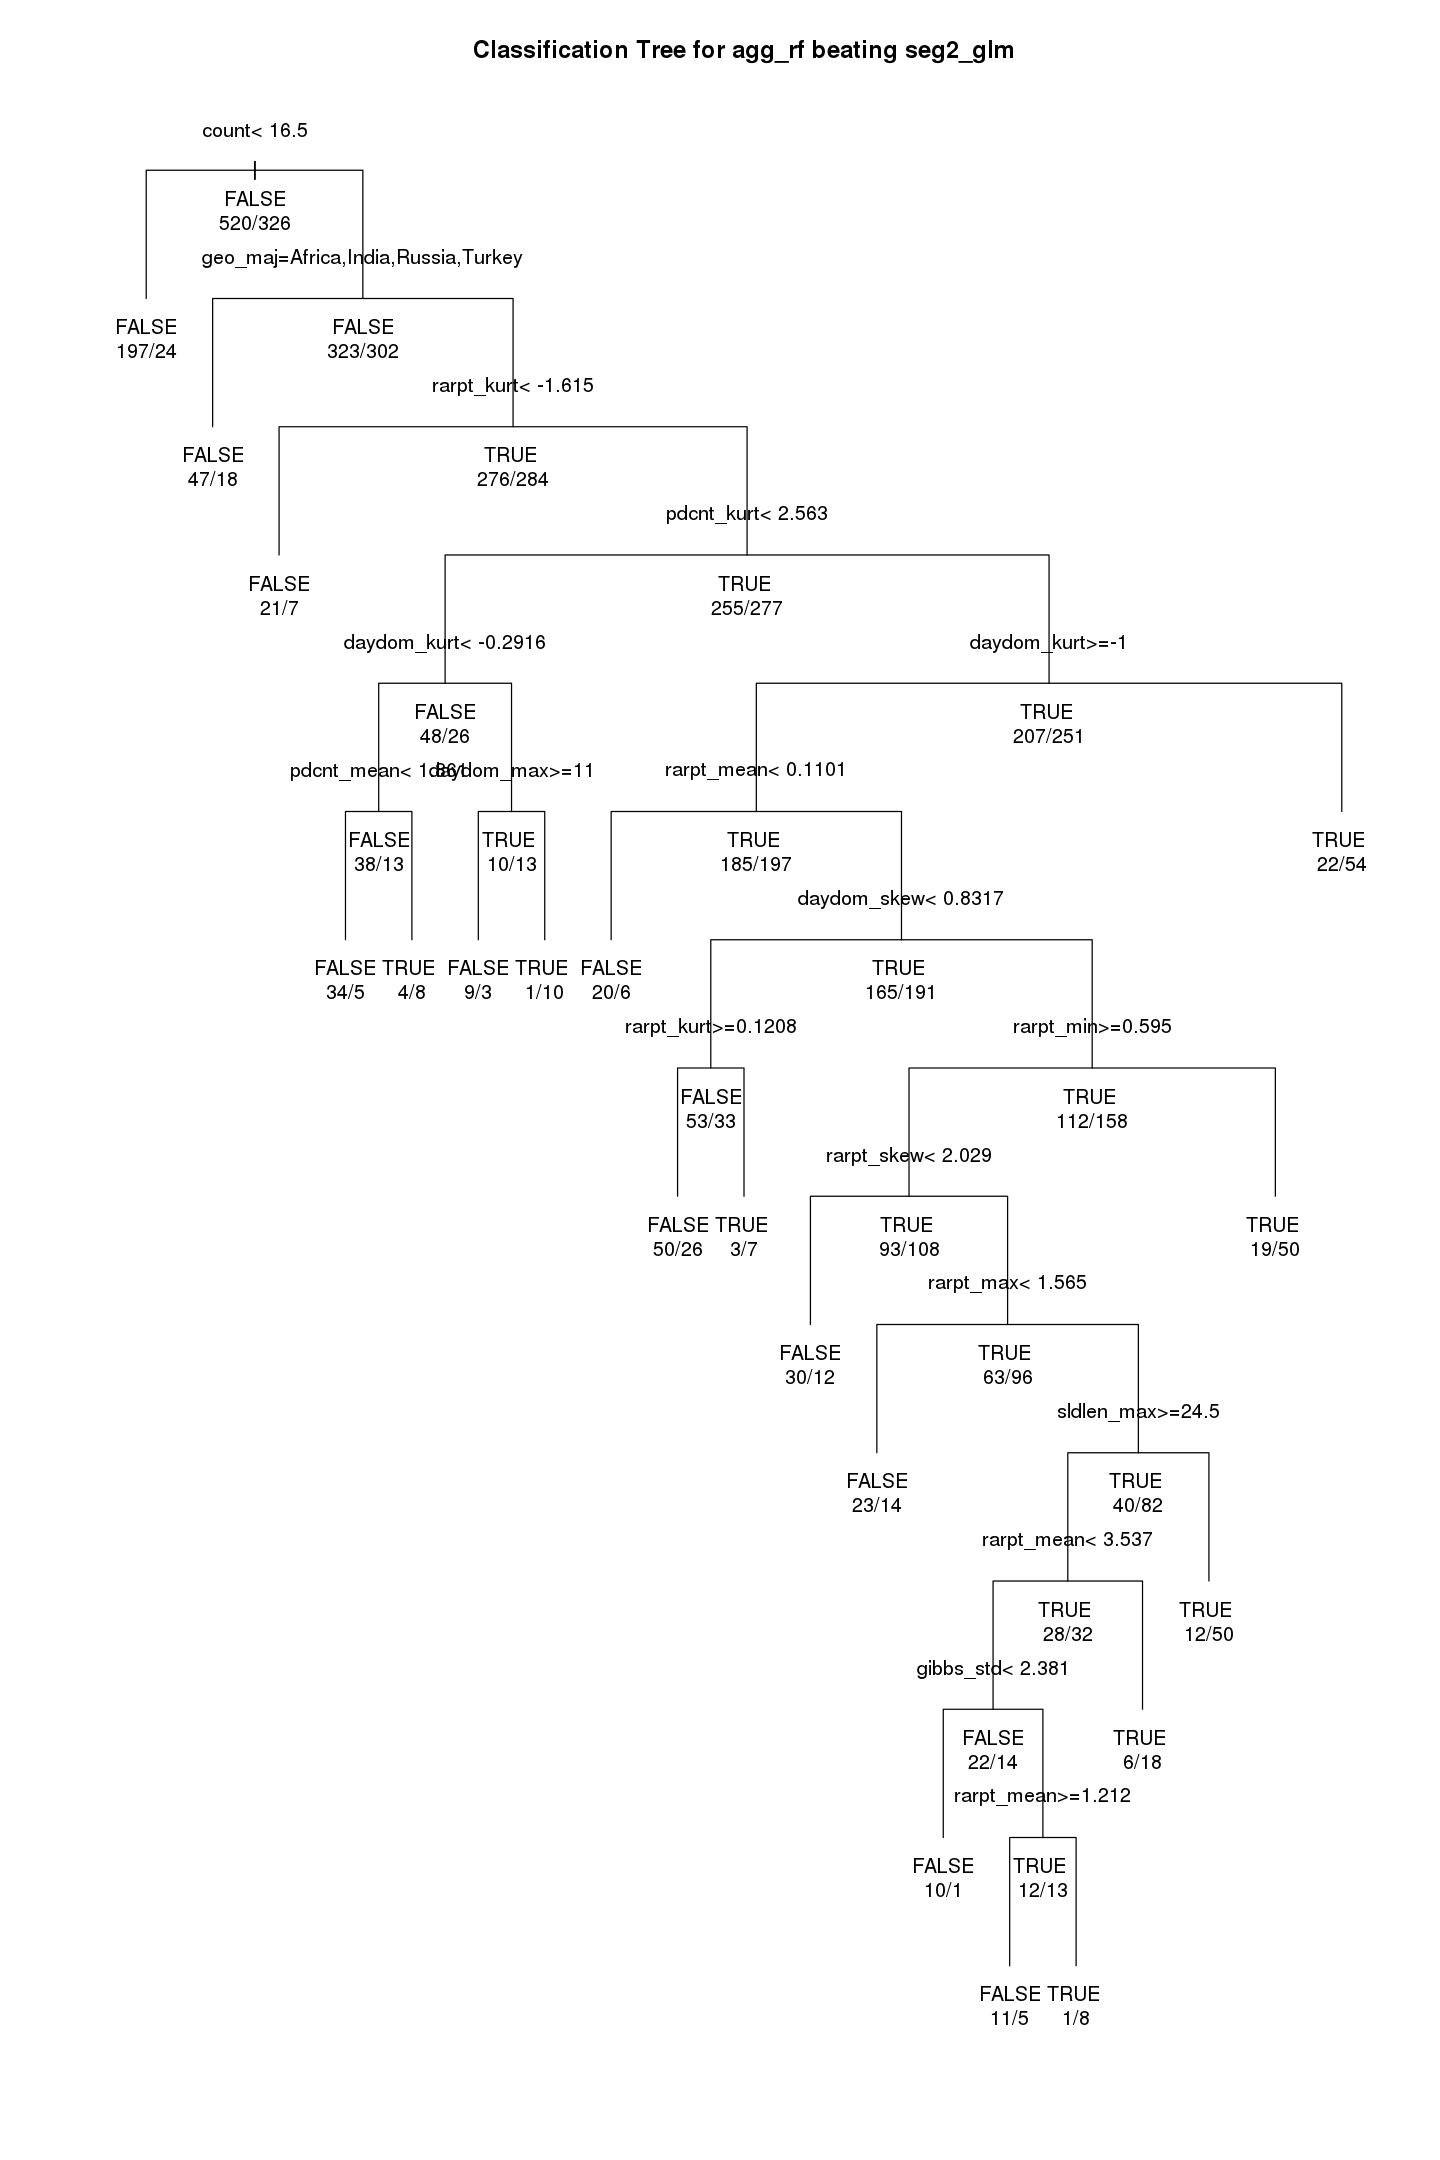

In [100]:
# plot tree
options(repr.plot.width=12, repr.plot.height=18)
plot(fit, uniform=TRUE,
   main="Classification Tree for agg_rf beating seg2_glm", use.n=TRUE)
text(fit, use.n=TRUE, all=TRUE, cex=1, pretty=1)

Interpretation:
- If count of domains is less than or equal to 16, then seg2_glm wins
- O/w, if count of domains is greater than 17 & geo_maj is one of Africa,India,Russia,Turkey, then seg2_glm wins
- O/w, if count of domains is greater than 17 & geo_maj is NOT one of Africa,India,Russia,Turkey, and kurtosis of reg_arpt>-1.62, pattern_domain_count>2,56 and/or day_domains<-1 then agg_rf wins



In [101]:
library(rpart.plot)

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


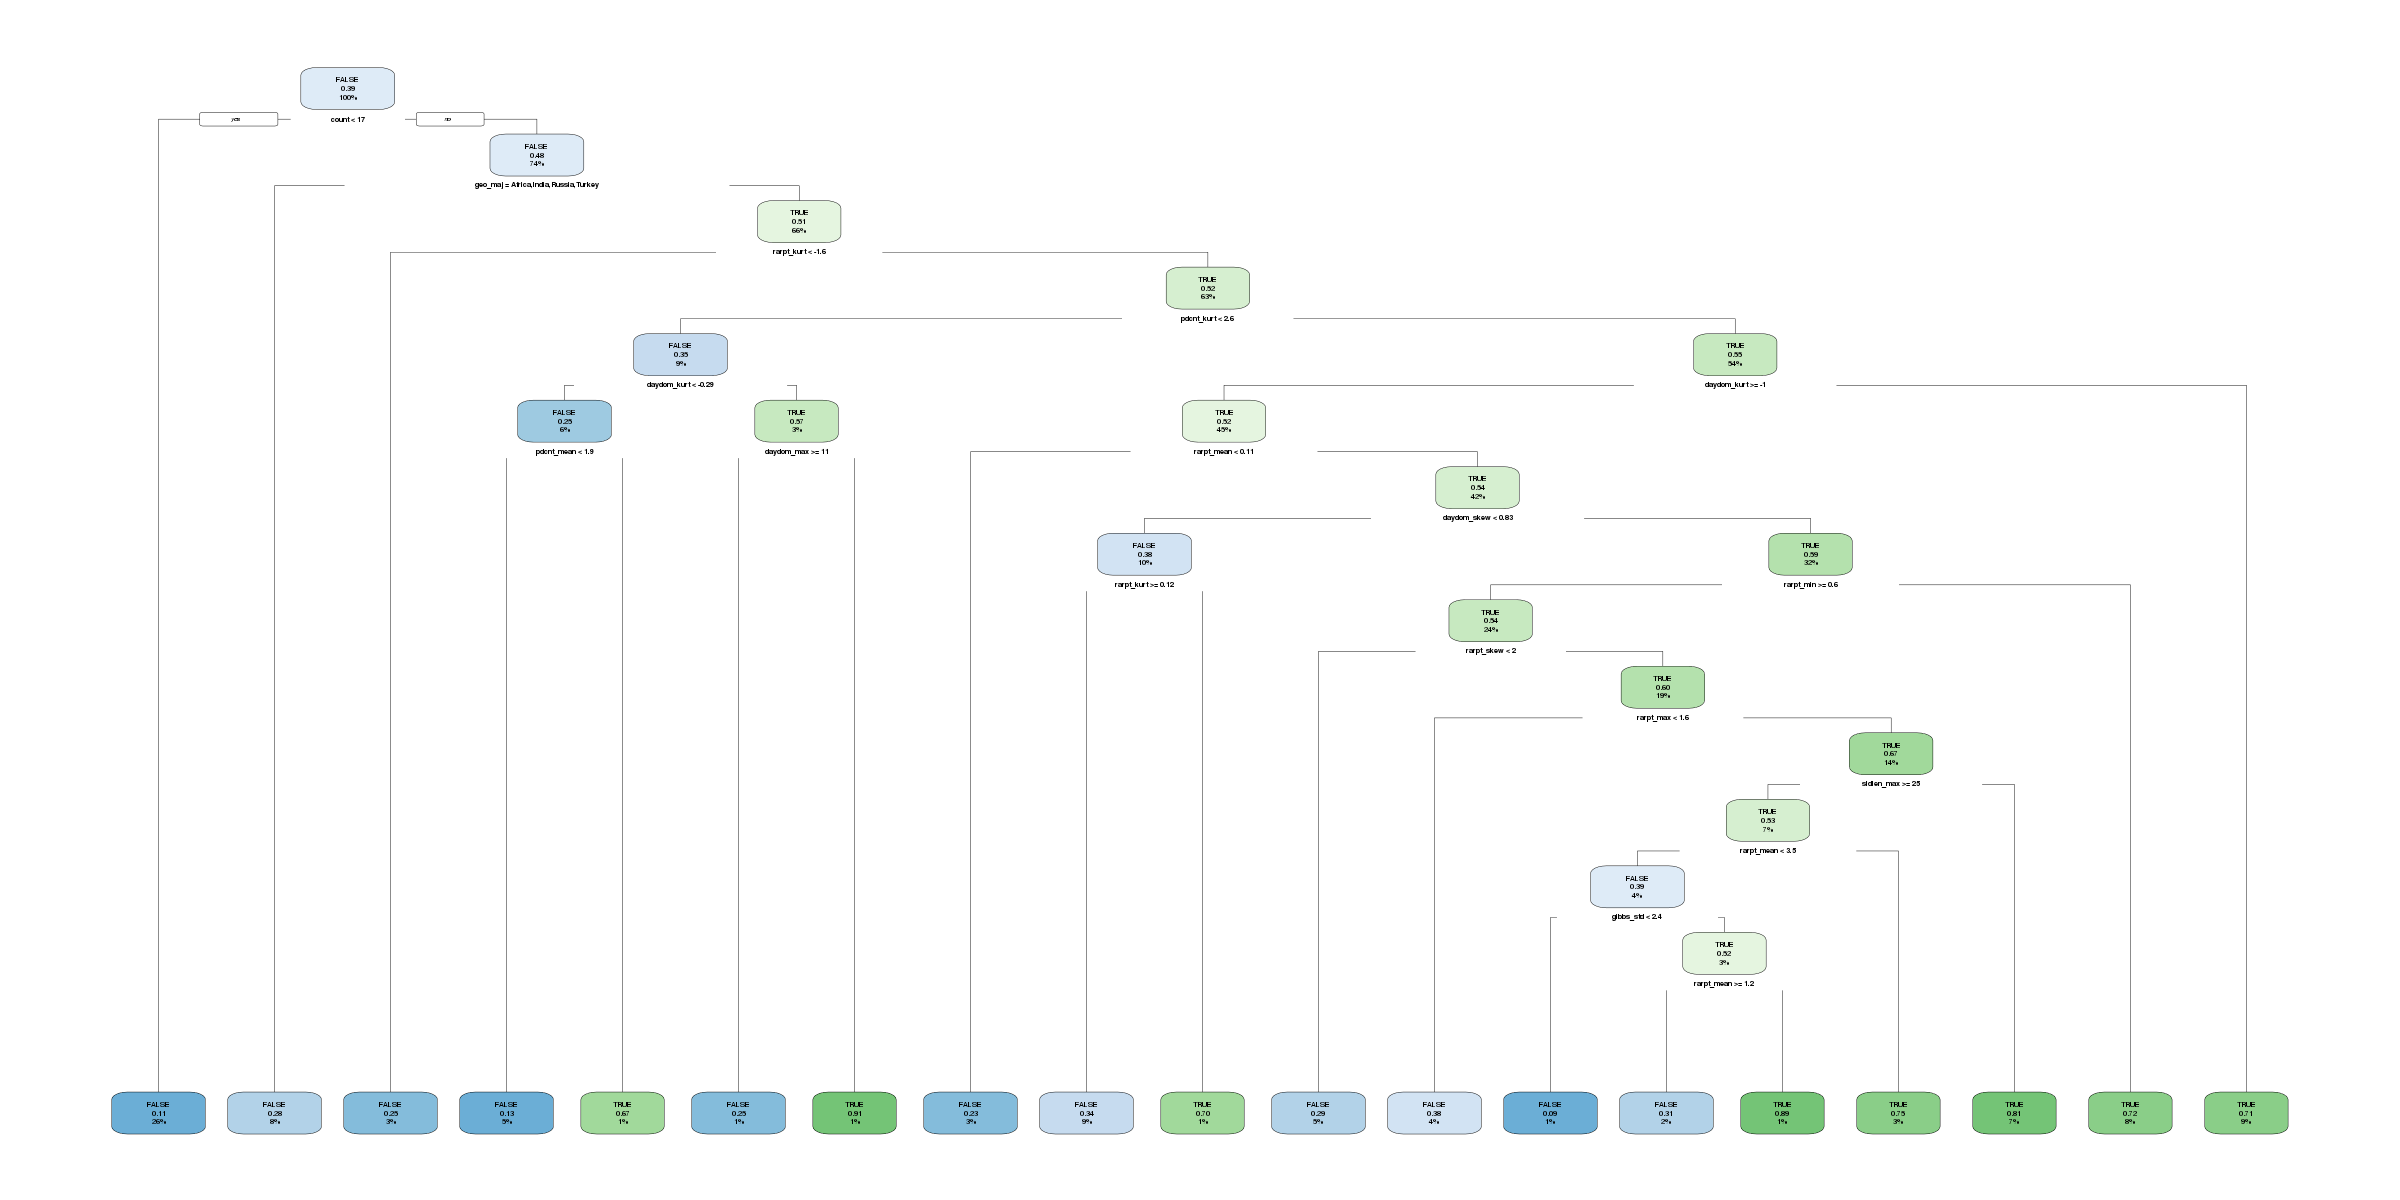

In [102]:
options(repr.plot.width=20, repr.plot.height=10)
rpart.plot(fit)

In [103]:
fit$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.03374233,0,1.0000000,1.000000,0.04342179
2,0.02760736,7,0.7607362,1.064417,0.04388461
3,0.01380368,10,0.6779141,1.092025,0.04404740
4,0.01226994,12,0.6503067,1.073620,0.04394122
5,0.01073620,16,0.6012270,1.092025,0.04404740
6,0.01000000,18,0.5797546,1.082822,0.04399548


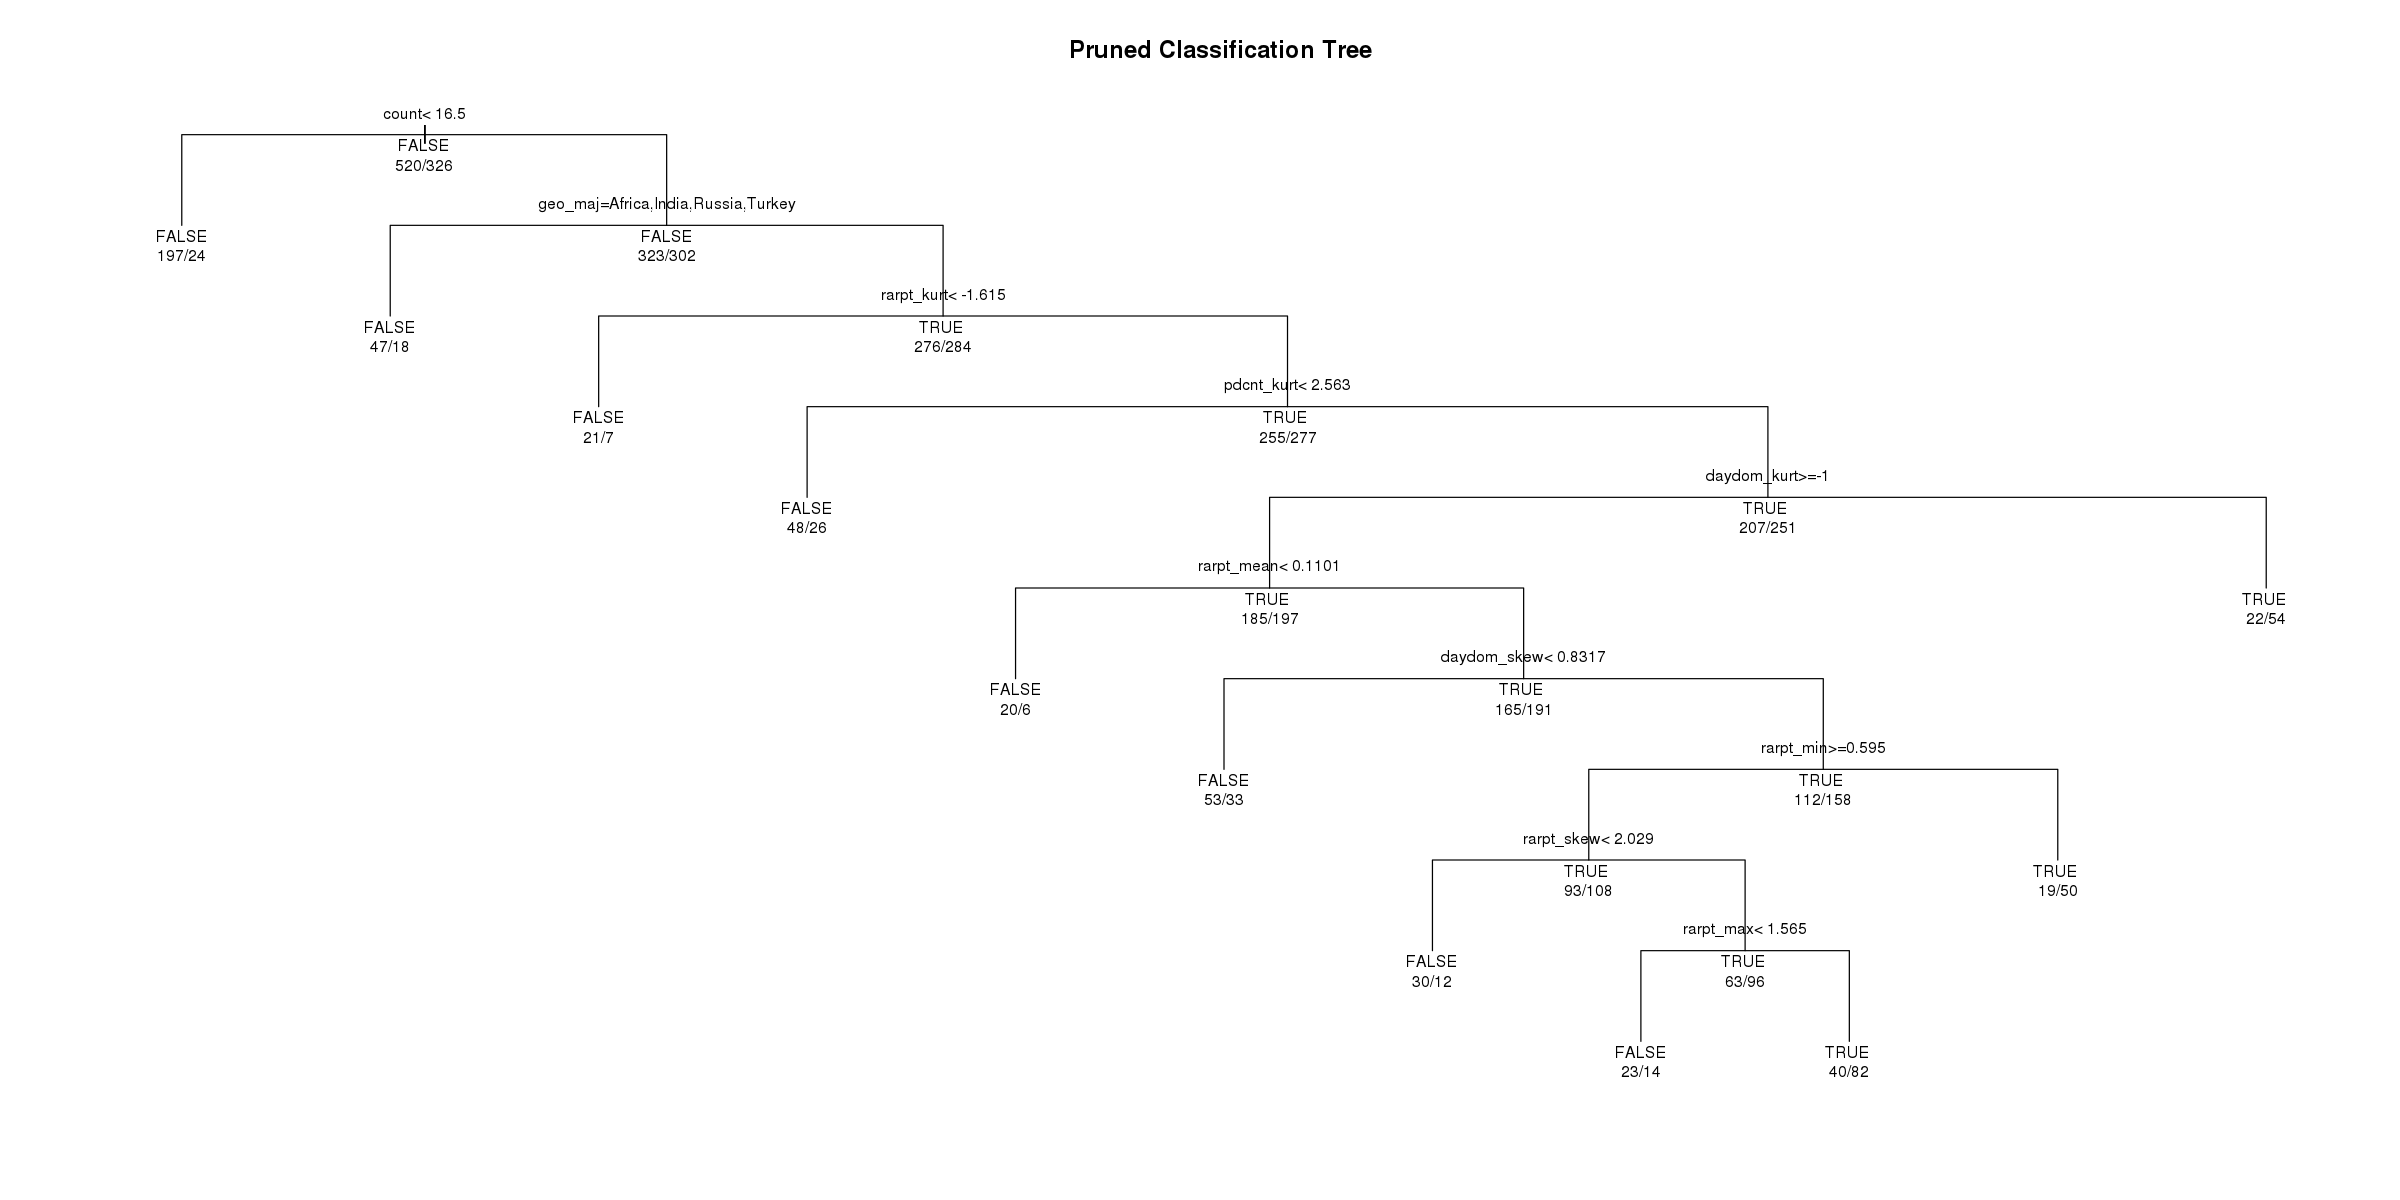

In [105]:
# prune the tree
# pfit<- prune(fit, cp=   fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
pfit<- prune(fit, cp= .02)

# plot the pruned tree
plot(pfit, uniform=TRUE,
   main="Pruned Classification Tree ")
text(pfit, use.n=TRUE, all=TRUE, cex=.8, pretty=1)

In [106]:
t = factor(predict(fit,test,type="class"))

In [107]:
p = factor(test[['auc_win_glmagg_glmseg2_rfagg']])

In [108]:
length(t)
length(p)

[1] 212

[1] 0

In [109]:
test[['auc_win_aggseg2']]

[1]  TRUE  TRUE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE
 [13]  TRUE FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE
 [25] FALSE  TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE
 [37]  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE
 [49] FALSE  TRUE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE
 [61]  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE
 [73] FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE
 [85] FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE
 [97]  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE
[109] FALSE FALSE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE
[121] FALSE FALSE FALSE  TRUE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE
[133]  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE
[145] FALSE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE
[157] FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[169] FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE
[181] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [110]:
factor(predict(fit,test,type="class"))

1     3     7    12    14    15    22    27    28    32    35    43    47 
 TRUE  TRUE FALSE FALSE  TRUE  TRUE  TRUE FALSE  TRUE FALSE FALSE FALSE  TRUE 
   60    62    63    66    70    73    75    86    97   101   102   109   118 
 TRUE FALSE  TRUE  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE 
  126   131   132   133   140   144   147   149   150   154   156   157   174 
FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE 
  176   183   187   192   198   202   208   213   214   216   233   257   269 
 TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE 
  272   273   276   283   285   288   290   293   300   305   307   313   314 
FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE 
  318   321   325   329   350   353   354   355   360   363   366   370   380 
FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE  TRUE FALSE FALSE FALSE 
  383   385   387   394   400   405   406   408   411   416   434   439   443 
 TRUE FALSE FALSE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE FALSE 
  451   454   460   462   469   471   481   485   492   496   502   506   510 
 TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE 
  514   518   525   529   531   540   550   551   556   561   565   568   571 
FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE 
  572   582   586   592   595   603   604   607   613   620   621   628   631 
 TRUE FALSE FALSE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE 
  632   634   636   641   642   645   647   652   659   661   670   676   681 
FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE 
  689   691   701   705   707   708   715   729   731   746   758   768   773 
 TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE 
  782   788   796   798   803   805   811   812   813   821   826   829   834 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  837   838   849   850   852   855   857   863   869   870   874   875   883 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  886   894   897   902   917   939   940   942   951   955   960   966   969 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  974   987   995  1001  1002  1003  1004  1009  1012  1016  1018  1019  1030 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
 1032  1035  1041  1049 
FALSE FALSE FALSE FALSE 
Levels: FALSE TRUE

In [111]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(fit,test,type="class")))#, positive='1')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    96   46
     TRUE     49   21
                                        
               Accuracy : 0.5519        
                 95% CI : (0.4823, 0.62)
    No Information Rate : 0.684         
    P-Value [Acc > NIR] : 1.0000        
                                        
                  Kappa : -0.0242       
                                        
 Mcnemar's Test P-Value : 0.8374        
                                        
            Sensitivity : 0.6621        
            Specificity : 0.3134        
         Pos Pred Value : 0.6761        
         Neg Pred Value : 0.3000        
             Prevalence : 0.6840        
         Detection Rate : 0.4528        
   Detection Prevalence : 0.6698        
      Balanced Accuracy : 0.4878        
                                        
       'Positive' Class : FALSE         
                                        

In [112]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(pfit,test,type="class")))#, positive='1')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   100   42
     TRUE     48   22
                                          
               Accuracy : 0.5755          
                 95% CI : (0.5059, 0.6429)
    No Information Rate : 0.6981          
    P-Value [Acc > NIR] : 0.9999          
                                          
                  Kappa : 0.0189          
                                          
 Mcnemar's Test P-Value : 0.5982          
                                          
            Sensitivity : 0.6757          
            Specificity : 0.3438          
         Pos Pred Value : 0.7042          
         Neg Pred Value : 0.3143          
             Prevalence : 0.6981          
         Detection Rate : 0.4717          
   Detection Prevalence : 0.6698          
      Balanced Accuracy : 0.5097          
                                          
       'Positive' Class : FALSE           
                     

### seg_rf over seg2_glm

In [113]:
library(rpart)

In [114]:
train$auc_win_segseg2 = (train$auc_seg_rf/train$auc_seg2_glm)>1
test$auc_win_segseg2 = (test$auc_seg_rf/test$auc_seg2_glm)>1

In [115]:
names(train)

[1] "l10_seg2_glm"    "l10_seg_glm"     "l10_agg_glm"     "l10_seg2_rf"    
 [5] "l10_seg_rf"      "l10_agg_rf"      "auc_seg2_glm"    "auc_seg_glm"    
 [9] "auc_agg_glm"     "auc_seg2_rf"     "auc_seg_rf"      "auc_agg_rf"     
[13] "tld_reseller"    "count"           "ren_prp"         "tld_rat"        
[17] "country_maj"     "region_maj"      "country_cnt"     "region_cnt"     
[21] "geo_cnt"         "geo_maj"         "daydom_min"      "daydom_max"     
[25] "daydom_mean"     "daydom_rng"      "daydom_std"      "daydom_skew"    
[29] "daydom_kurt"     "sldlen_min"      "sldlen_max"      "sldlen_mean"    
[33] "sldlen_rng"      "sldlen_std"      "sldlen_skew"     "sldlen_kurt"    
[37] "gibbs_min"       "gibbs_max"       "gibbs_mean"      "gibbs_rng"      
[41] "gibbs_std"       "gibbs_skew"      "gibbs_kurt"      "pdcnt_min"      
[45] "pdcnt_max"       "pdcnt_mean"      "pdcnt_rng"       "pdcnt_std"      
[49] "pdcnt_skew"      "pdcnt_kurt"      "rarpt_min"       "rarpt_max"      
[53] "rarpt_mean"      "rarpt_rng"       "rarpt_std"       "rarpt_skew"     
[57] "rarpt_kurt"      "auc_win"         "l10_win"         "l10_win_aggseg2"
[61] "auc_win_aggseg2" "auc_win_segseg2"

In [116]:
fit <- rpart(auc_win_segseg2 ~ .,
             method="class", 
             data=subset(train, select = -c(tld_reseller,
                                            country_maj,region_maj,country_cnt,region_cnt,
                                            l10_seg2_glm,l10_seg_glm,l10_agg_glm,l10_seg2_rf,l10_seg_rf,l10_agg_rf,
                                            auc_seg2_glm,auc_seg_glm,auc_agg_glm,auc_seg2_rf,auc_seg_rf,auc_agg_rf,
                                            auc_win,l10_win,l10_win_aggseg2,auc_win_aggseg2)))

In [117]:
summary(fit)

Call:
rpart(formula = auc_win_segseg2 ~ ., data = subset(train, select = -c(tld_reseller, 
    country_maj, region_maj, country_cnt, region_cnt, l10_seg2_glm, 
    l10_seg_glm, l10_agg_glm, l10_seg2_rf, l10_seg_rf, l10_agg_rf, 
    auc_seg2_glm, auc_seg_glm, auc_agg_glm, auc_seg2_rf, auc_seg_rf, 
    auc_agg_rf, auc_win, l10_win, l10_win_aggseg2, auc_win_aggseg2)), 
    method = "class")
  n= 846 

          CP nsplit rel error   xerror       xstd
1 0.02916667      0  1.000000 1.000000 0.04407910
2 0.02250000      4  0.853125 1.003125 0.04410593
3 0.01875000     10  0.709375 1.025000 0.04428602
4 0.01250000     12  0.671875 1.021875 0.04426112
5 0.01000000     15  0.634375 1.037500 0.04438288

Variable importance
      count     tld_rat daydom_mean  daydom_rng  daydom_max   gibbs_rng 
         14          14          12          12          11           8 
 daydom_std sldlen_skew  rarpt_kurt daydom_skew daydom_kurt sldlen_kurt 
          5           3           3           2           

In [118]:
levels(train$country_maj)

[1] ""               "Argentina"      "Australia"      "Austria"       
 [5] "Belgium"        "Brazil"         "Bulgaria"       "Canada"        
 [9] "Cayman Islands" "China"          "Cyprus"         "Czech Republic"
[13] "Denmark"        "Finland"        "France"         "Germany"       
[17] "Gibraltor"      "Greece"         "India"          "Indonesia"     
[21] "Ireland"        "Israel"         "Italy"          "Japan"         
[25] "Korea"          "Lithuania"      "Luxembourg"     "Mexico"        
[29] "Netherlands"    "New Zealand"    "Nigeria"        "Norway"        
[33] "Poland"         "Portugal"       "Russia"         "Singapore"     
[37] "Slovakia"       "South Africa"   "Southafrica"    "Spain"         
[41] "Sweden"         "Switzerland"    "Turkey"         "Ukraine"       
[45] "United Kingdom" "United States"  "USA"            "Vietnam"

In [119]:
names(fit)

[1] "frame"               "where"               "call"               
 [4] "terms"               "cptable"             "method"             
 [7] "parms"               "control"             "functions"          
[10] "numresp"             "splits"              "csplit"             
[13] "variable.importance" "y"                   "ordered"

In [120]:
fit

n= 846 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

   1) root 846 320 FALSE (0.6217494 0.3782506)  
     2) count< 16.5 221  25 FALSE (0.8868778 0.1131222) *
     3) count>=16.5 625 295 FALSE (0.5280000 0.4720000)  
       6) rarpt_kurt< -1.58572 37   6 FALSE (0.8378378 0.1621622) *
       7) rarpt_kurt>=-1.58572 588 289 FALSE (0.5085034 0.4914966)  
        14) sldlen_skew< 2.009465 528 245 FALSE (0.5359848 0.4640152)  
          28) daydom_std>=0.4403479 491 217 FALSE (0.5580448 0.4419552)  
            56) daydom_max>=11.5 225  84 FALSE (0.6266667 0.3733333)  
             112) pdcnt_mean>=1.036734 217  77 FALSE (0.6451613 0.3548387)  
               224) daydom_std< 75.18911 191  61 FALSE (0.6806283 0.3193717)  
                 448) rarpt_kurt>=-1.021768 181  54 FALSE (0.7016575 0.2983425) *
                 449) rarpt_kurt< -1.021768 10   3 TRUE (0.3000000 0.7000000) *
               225) daydom_std>=75.18911 26  10 TRUE (0.3846154 0.6153846) *
         

Warning message in plot.window(...):
“"use.n" is not a graphical parameter”
Warning message in plot.xy(xy, type, ...):
“"use.n" is not a graphical parameter”
Warning message in title(...):
“"use.n" is not a graphical parameter”


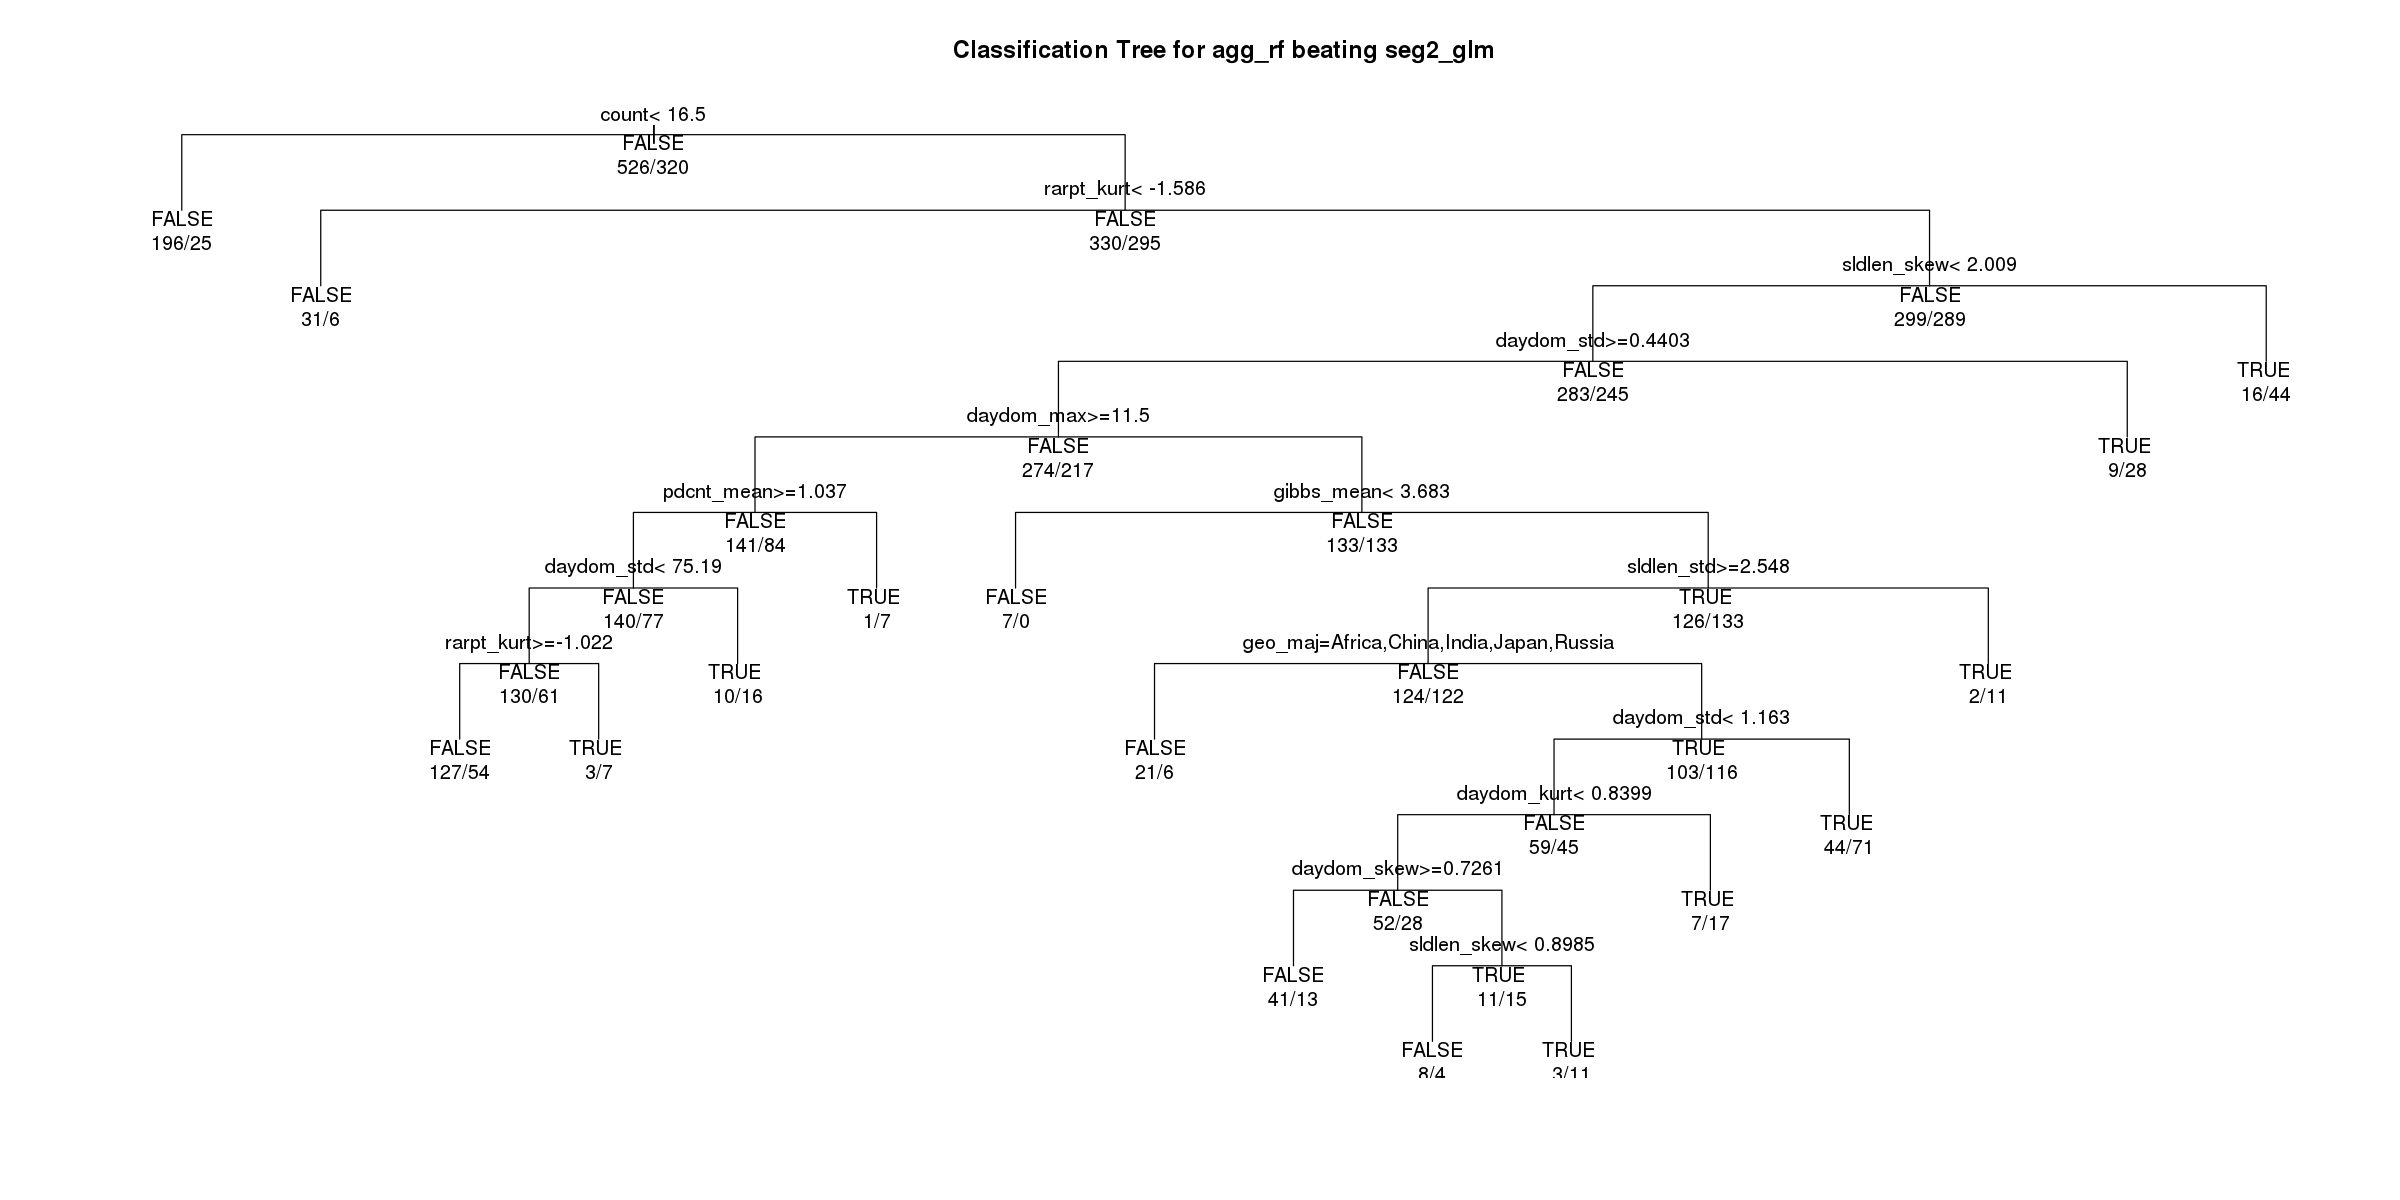

In [121]:
# plot tree
plot(fit, uniform=TRUE,
   main="Classification Tree for agg_rf beating seg2_glm", use.n=TRUE)
text(fit, use.n=TRUE, all=TRUE, cex=1, pretty=1)

Interpretation:
- If count of domains is less than or equal to 16, then seg2_glm wins
- Otherwise, if county_maj is one of <s>Cyprus,</s> **Denmark**, Greece, India, **Indonesia**,Lithuania, Luxembourg, <s>Nigeria</s>, Norway, Portugal, Russia, Slovakia, Spain, Sweden, <s>Switzerland</s>, Turkey, <s>Ukraine,Vietnam</s>, **United Kindon** AND daydpom_skew is < <s>1.68</s> 1.74, then seg2_glm wins... IF  daydpom_skew is >= <s>1.68</s> 1.74 but gibbs_mean < 5.172 then seg2_glm wins

In [122]:
library(rpart.plot)

Warning message:
“Bad 'data' field in model 'call' (expected a data.frame or a matrix).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


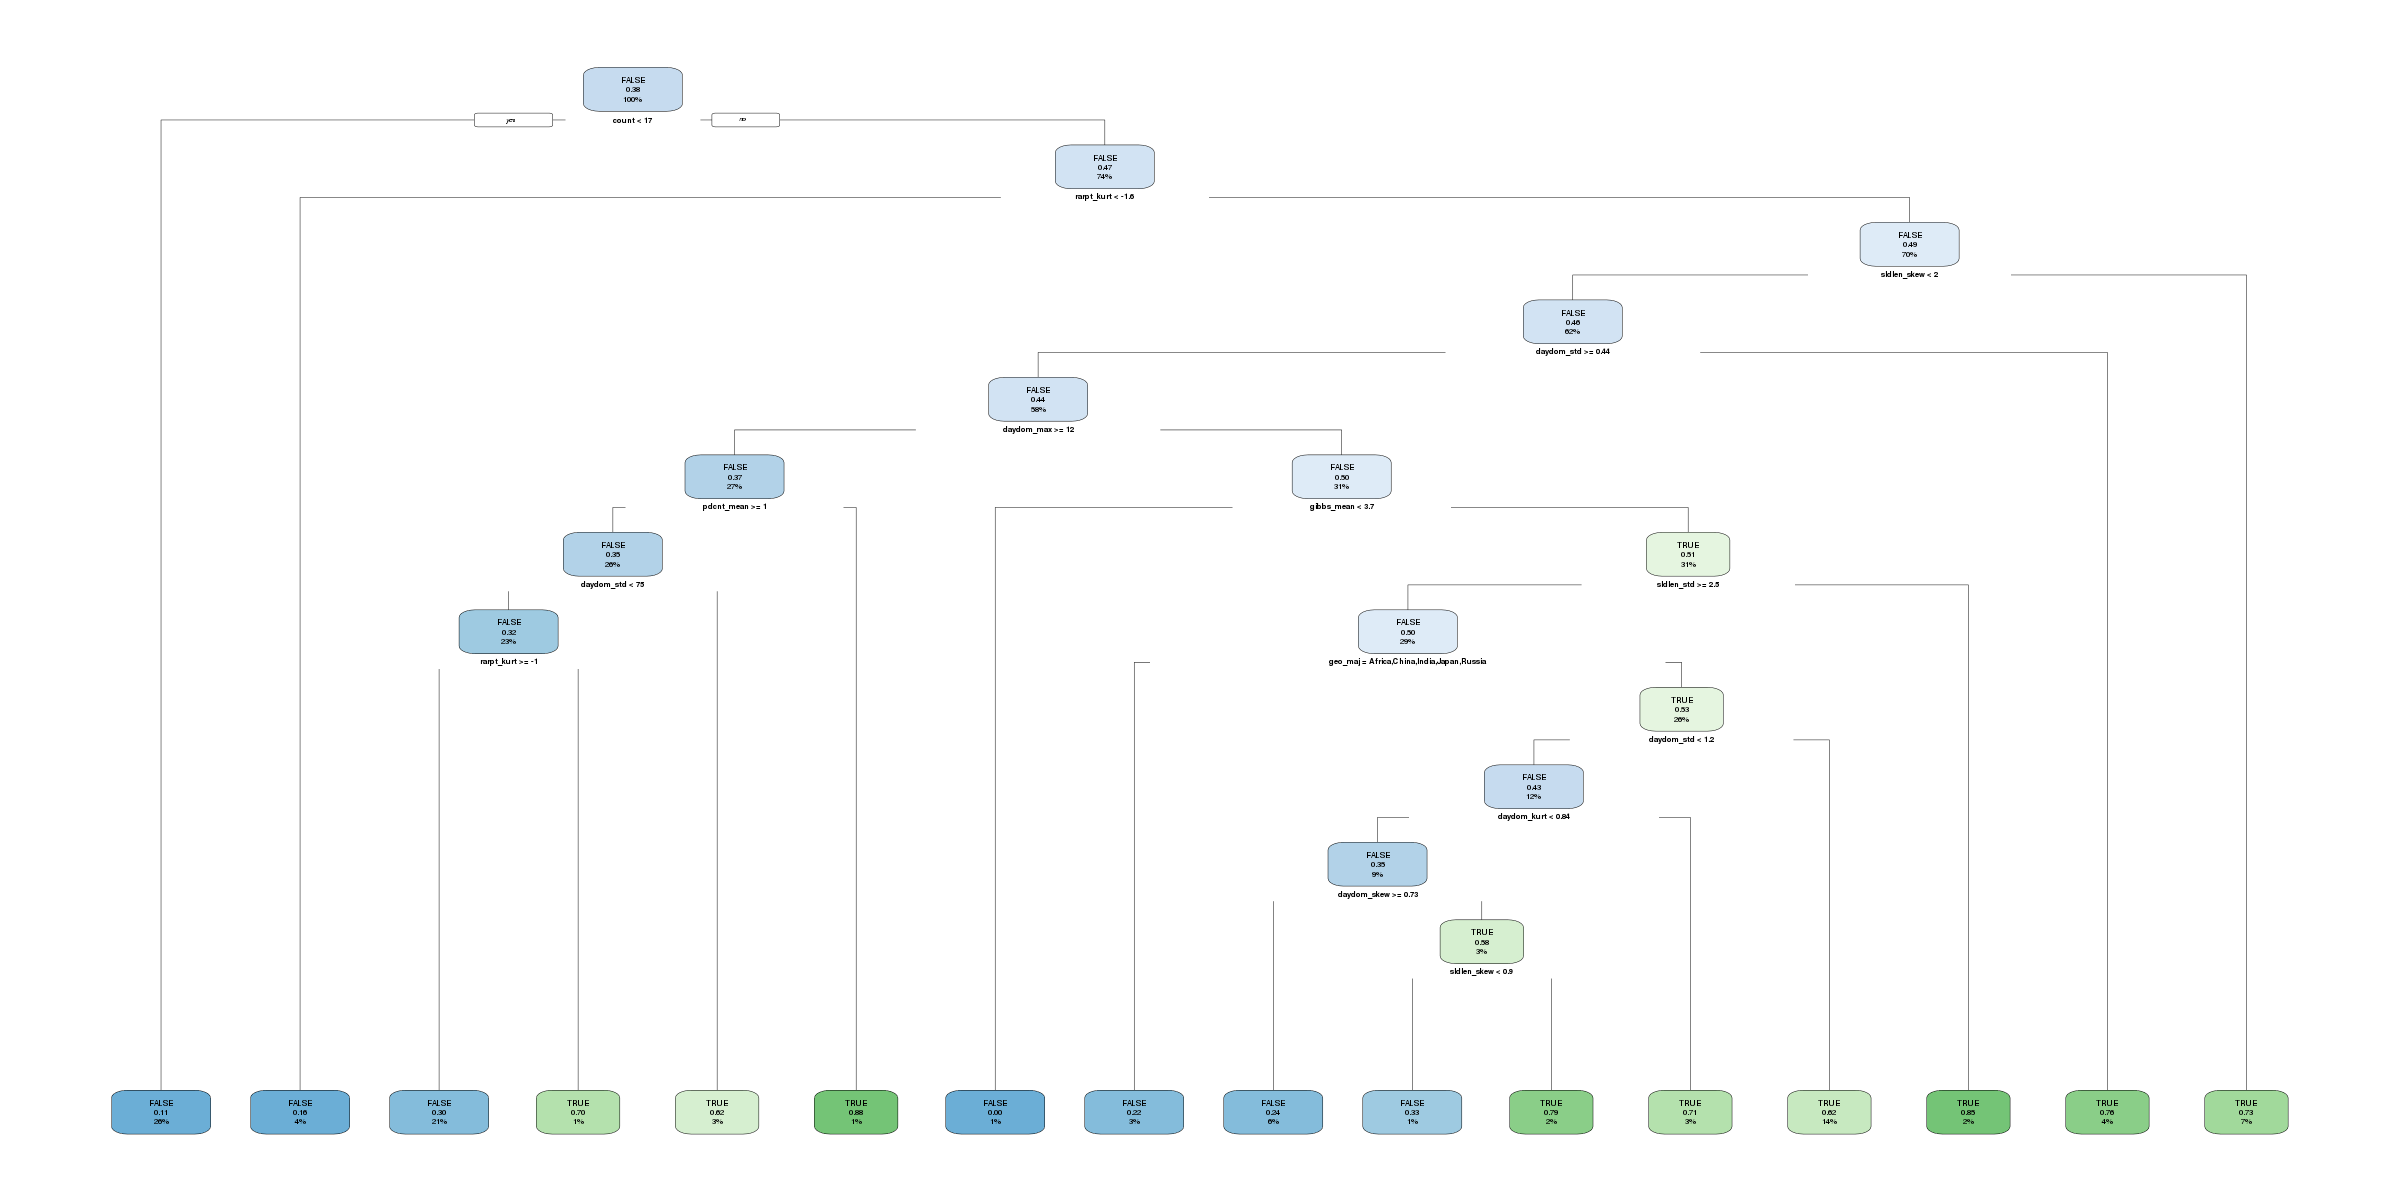

In [123]:
options(repr.plot.width=20, repr.plot.height=10)
rpart.plot(fit)

In [124]:
fit$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.02916667,0,1.000000,1.000000,0.04407910
2,0.02250000,4,0.853125,1.003125,0.04410593
3,0.01875000,10,0.709375,1.025000,0.04428602
4,0.01250000,12,0.671875,1.021875,0.04426112
5,0.01000000,15,0.634375,1.037500,0.04438288


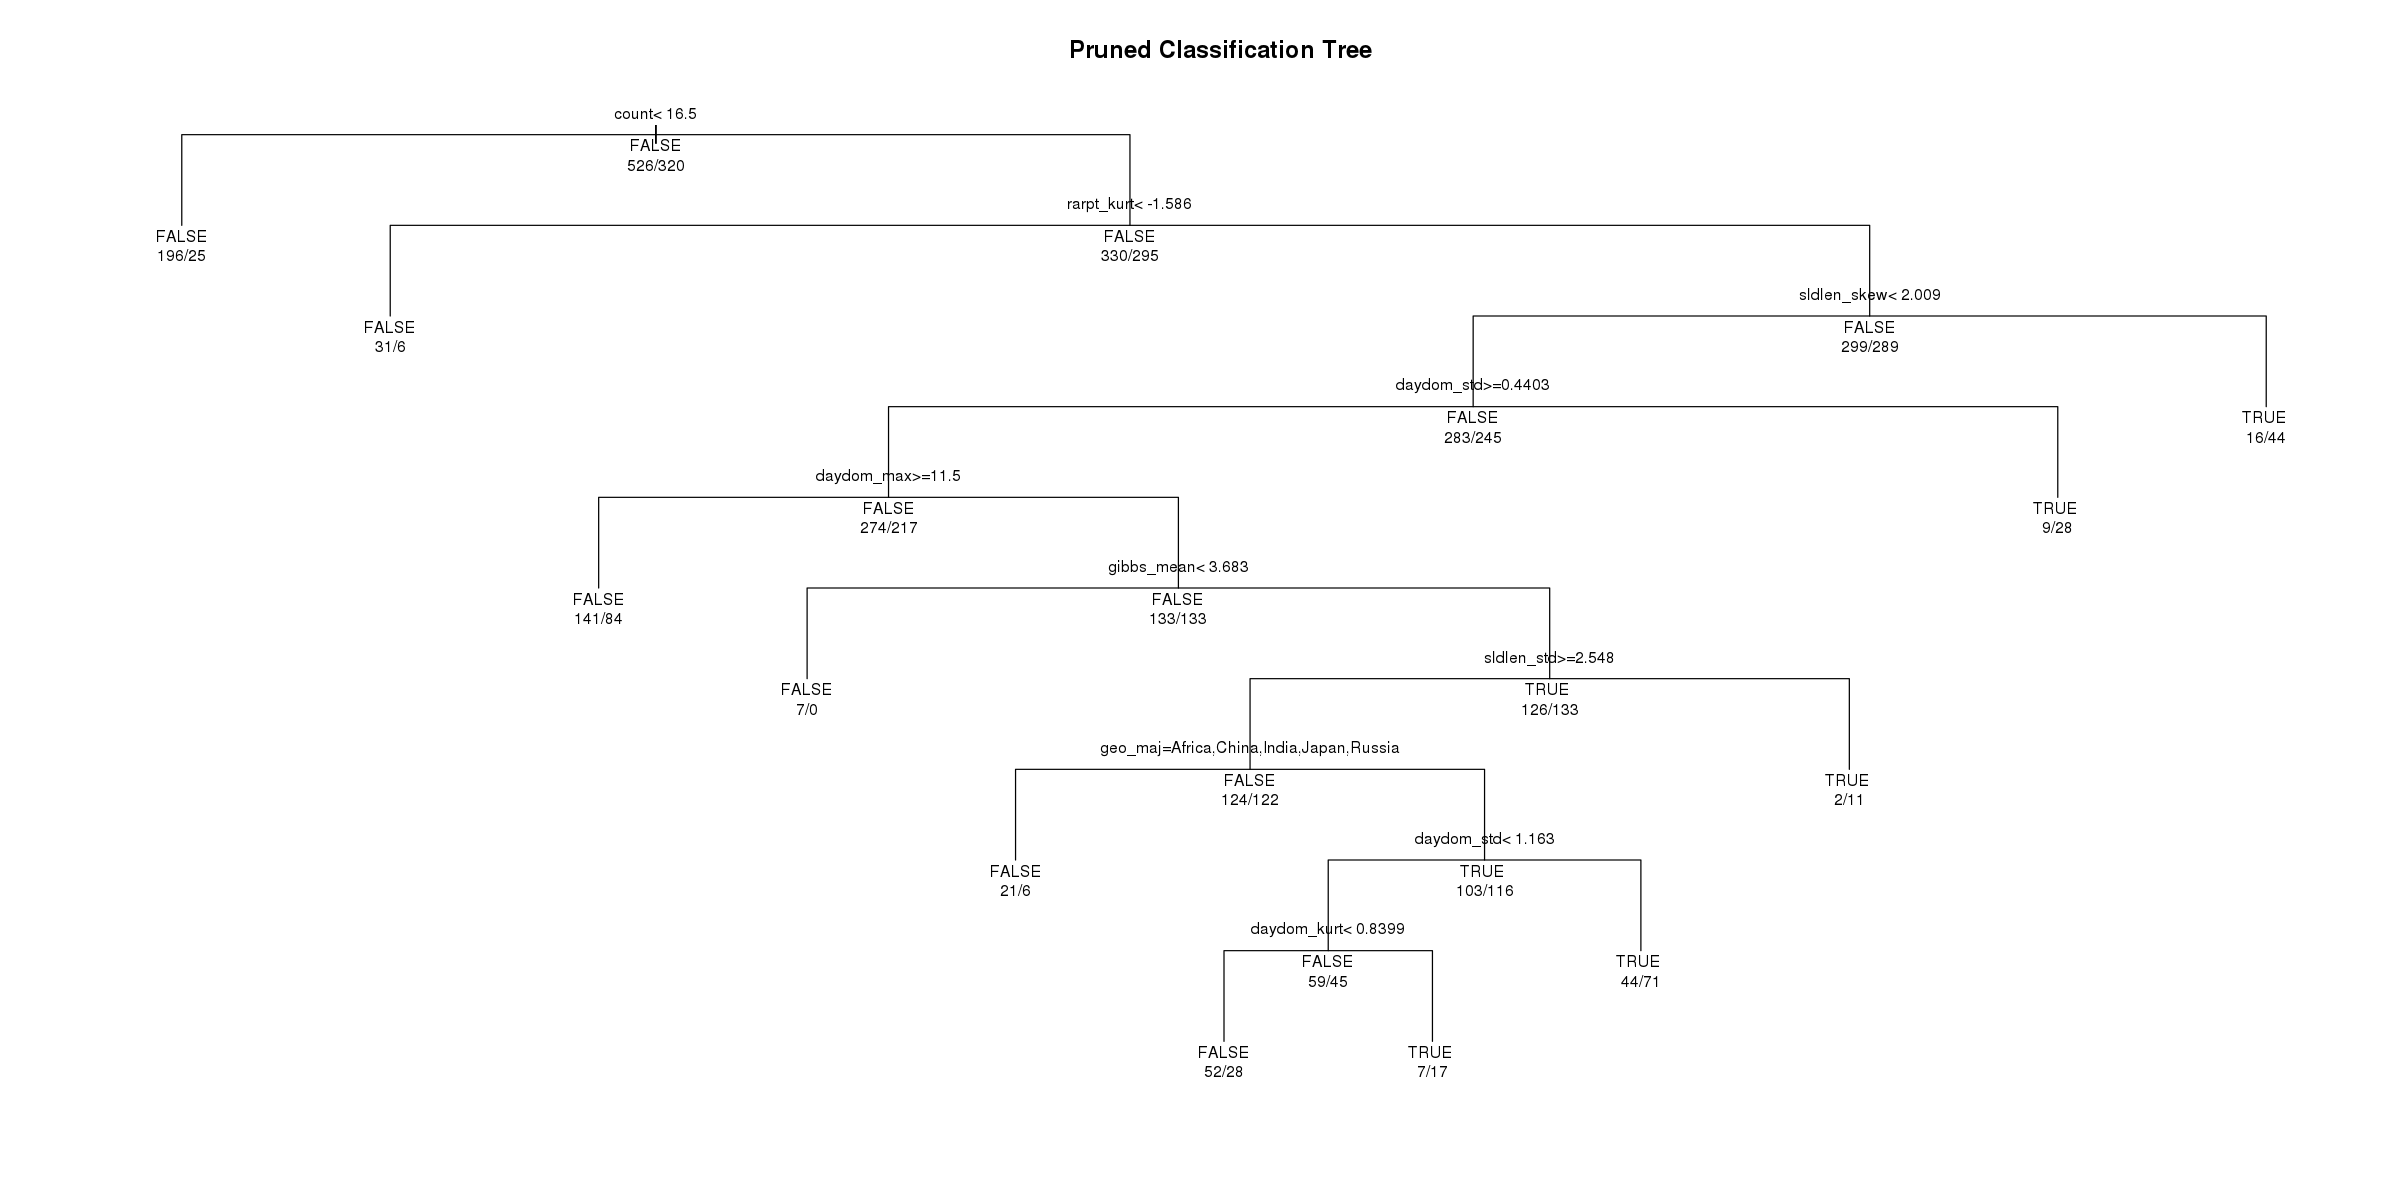

In [134]:
# prune the tree
# pfit<- prune(fit, cp=   fit$cptable[which.min(fit$cptable[,"xerror"]),"CP"])
pfit<- prune(fit, cp= .02)

# plot the pruned tree
plot(pfit, uniform=TRUE,
   main="Pruned Classification Tree ")
text(pfit, use.n=TRUE, all=TRUE, cex=.8, pretty=1)

In [135]:
summary(train$count)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    1.00    15.25    72.50   956.02   316.75 72690.00 

In [136]:
t = factor(predict(fit,test,type="class"))

In [137]:
p = factor(test[['auc_win_glmagg_glmseg2_rfagg']])

In [138]:
length(t)
length(p)

[1] 212

[1] 0

In [139]:
test[['auc_win_segseg2']]

[1]  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
 [13]  TRUE FALSE  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE
 [25] FALSE  TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE FALSE  TRUE FALSE
 [37]  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE  TRUE
 [49]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE
 [61]  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE FALSE
 [73] FALSE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE  TRUE
 [85] FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE
 [97] FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE
[109] FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE
[121] FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE
[133] FALSE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE
[145] FALSE FALSE  TRUE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE FALSE FALSE
[157] FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[169] FALSE  TRUE FALSE FALSE FALSE  TRUE  TRUE FALSE  TRUE FALSE FALSE  TRUE
[181] FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE
[193] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[205] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [140]:
factor(predict(fit,test,type="class"))

1     3     7    12    14    15    22    27    28    32    35    43    47 
 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE 
   60    62    63    66    70    73    75    86    97   101   102   109   118 
FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE FALSE 
  126   131   132   133   140   144   147   149   150   154   156   157   174 
 TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE FALSE 
  176   183   187   192   198   202   208   213   214   216   233   257   269 
FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE FALSE FALSE 
  272   273   276   283   285   288   290   293   300   305   307   313   314 
FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE  TRUE FALSE 
  318   321   325   329   350   353   354   355   360   363   366   370   380 
 TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE  TRUE 
  383   385   387   394   400   405   406   408   411   416   434   439   443 
FALSE FALSE FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE FALSE  TRUE  TRUE  TRUE 
  451   454   460   462   469   471   481   485   492   496   502   506   510 
FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE 
  514   518   525   529   531   540   550   551   556   561   565   568   571 
FALSE FALSE  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE  TRUE FALSE FALSE 
  572   582   586   592   595   603   604   607   613   620   621   628   631 
 TRUE  TRUE FALSE  TRUE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE FALSE  TRUE 
  632   634   636   641   642   645   647   652   659   661   670   676   681 
 TRUE  TRUE FALSE FALSE FALSE FALSE FALSE  TRUE  TRUE  TRUE FALSE FALSE FALSE 
  689   691   701   705   707   708   715   729   731   746   758   768   773 
FALSE  TRUE FALSE FALSE FALSE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE 
  782   788   796   798   803   805   811   812   813   821   826   829   834 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  837   838   849   850   852   855   857   863   869   870   874   875   883 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  886   894   897   902   917   939   940   942   951   955   960   966   969 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
  974   987   995  1001  1002  1003  1004  1009  1012  1016  1018  1019  1030 
FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE 
 1032  1035  1041  1049 
FALSE FALSE FALSE FALSE 
Levels: FALSE TRUE

In [141]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_segseg2']]),
                factor(predict(fit,test,type="class")))#, positive='1')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE    91   46
     TRUE     42   33
                                         
               Accuracy : 0.5849         
                 95% CI : (0.5154, 0.652)
    No Information Rate : 0.6274         
    P-Value [Acc > NIR] : 0.9107         
                                         
                  Kappa : 0.103          
                                         
 Mcnemar's Test P-Value : 0.7491         
                                         
            Sensitivity : 0.6842         
            Specificity : 0.4177         
         Pos Pred Value : 0.6642         
         Neg Pred Value : 0.4400         
             Prevalence : 0.6274         
         Detection Rate : 0.4292         
   Detection Prevalence : 0.6462         
      Balanced Accuracy : 0.5510         
                                         
       'Positive' Class : FALSE          
                                         

In [142]:
# pruned test prediction
confusionMatrix(factor(test[['auc_win_aggseg2']]),
                factor(predict(pfit,test,type="class")))#, positive='1')

Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   106   36
     TRUE     36   34
                                          
               Accuracy : 0.6604          
                 95% CI : (0.5924, 0.7238)
    No Information Rate : 0.6698          
    P-Value [Acc > NIR] : 0.6451          
                                          
                  Kappa : 0.2322          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.7465          
            Specificity : 0.4857          
         Pos Pred Value : 0.7465          
         Neg Pred Value : 0.4857          
             Prevalence : 0.6698          
         Detection Rate : 0.5000          
   Detection Prevalence : 0.6698          
      Balanced Accuracy : 0.6161          
                                          
       'Positive' Class : FALSE           
                     

# MultiClass DTree

In [145]:
dim(train)
dim(train_sub)
names(train_sub)

[1] 846  62

[1] 846  41

[1] "auc_win"     "count"       "ren_prp"     "tld_rat"     "geo_maj"    
 [6] "geo_cnt"     "daydom_min"  "daydom_max"  "daydom_mean" "daydom_rng" 
[11] "daydom_std"  "daydom_skew" "daydom_kurt" "sldlen_min"  "sldlen_max" 
[16] "sldlen_mean" "sldlen_rng"  "sldlen_std"  "sldlen_skew" "sldlen_kurt"
[21] "gibbs_min"   "gibbs_max"   "gibbs_mean"  "gibbs_rng"   "gibbs_std"  
[26] "gibbs_skew"  "gibbs_kurt"  "pdcnt_min"   "pdcnt_max"   "pdcnt_mean" 
[31] "pdcnt_rng"   "pdcnt_std"   "pdcnt_skew"  "pdcnt_kurt"  "rarpt_min"  
[36] "rarpt_max"   "rarpt_mean"  "rarpt_rng"   "rarpt_std"   "rarpt_skew" 
[41] "rarpt_kurt"

In [ ]:
str(train_sub)

In [ ]:
fit <- rpart(auc_win ~ .,
             method="class", 
             data=train_sub)

In [ ]:
summary(fit)